## 1. Configurações Iniciais


In [1]:
import os, json, random, warnings, numpy as np, pandas as pd
import urllib.request
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import ConfusionMatrixDisplay
from datasets import Dataset
import shap
import evaluate
import datasets as hfds
import torch
import arff
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, TensorDataset
from packaging import version as _pkgver
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, Trainer, TrainingArguments,
                          AutoModelForCausalLM, EarlyStoppingCallback)
warnings.filterwarnings("ignore")

try:
    from transformers import BitsAndBytesConfig
    from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
    HAS_PEFT = True
except Exception:
    HAS_PEFT = False

# UMAP é usado para redução dimensional mais “não linear”
try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False

# spaCy para tokenização mais robusta em português (opcional)
try:
    import spacy
    nlp_spacy = spacy.load("pt_core_news_sm", disable=["parser", "ner"])
    HAS_SPACY = True
except Exception:
    nlp_spacy = None
    HAS_SPACY = False

SEED = 42
random.seed(SEED); np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_prec = evaluate.load("precision")
metric_rec = evaluate.load("recall")

C:\Users\chita\OneDrive\Área de Trabalho\TCC\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.1 Parâmetros do experimento


In [2]:
CONFIGS = ["offcombr-2", "offcombr-3"]
TEST_SIZE = 0.20
MAX_FEATURES_TFIDF = 20000
TFIDF_EXPLORE_NGRAMS = (1, 2)  # n-grams for TF-IDF exploration
MAX_LEN_BERT = 256
BATCH_TRAIN = 16
BATCH_EVAL = 32
EPOCHS_BERT = 3
LR_BERT = 2e-5

# Preprocessing options
# ====================
# PRESERVE_ACCENTS: Se True, mantém acentos (melhor para negativos como "não", "não é")
#   - True: preserva "não" → útil para TF-IDF quando negativos são importantes
#   - False: remove acentos "não" → "nao" (padrão, mais compatível)
# USE_SPACY_TOKENIZER: Se True, usa spaCy pt_core_news_sm (mais robusto para português)
#   - True: melhor tokenização, preserva contrações/negativos
#   - False: usa NLTK (padrão, mais rápido)
# NOTA: Transformers (BERT/LLaMA) sempre usam texto bruto, então essas opções afetam apenas TF-IDF/RF/LogReg
PRESERVE_ACCENTS = False  # Se True, não remove acentos (melhor para negativos como "não")
USE_SPACY_TOKENIZER = False  # Se True, usa spaCy; caso contrário, NLTK

ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

In [3]:
# -------------------------
# Lista customizada de stopwords em Português
# -------------------------
STOPWORDS_PT = set([
    'a', 'à', 'adeus', 'agora', 'aí', 'ainda', 'além', 'algo', 'alguém', 'algum', 'alguma', 'algumas', 'alguns',
    'ali', 'ampla', 'amplas', 'amplo', 'amplos', 'ano', 'anos', 'ante', 'antes', 'ao', 'aos', 'apenas', 'apoio',
    'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'área', 'as', 'às', 'assim', 'até', 'atrás',
    'através', 'baixo', 'bastante', 'bem', 'boa', 'boas', 'bom', 'bons', 'breve', 'cá', 'cada', 'quatorze', 'cedo',
    'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'coisas', 'com', 'como', 'conselho', 'contra',
    'contudo', 'custa', 'da', 'dá', 'dão', 'daquela', 'daquelas', 'daquele', 'daqueles', 'dar', 'das', 'de', 'debaixo',
    'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'desde', 'dessa', 'dessas', 'desse', 'desses',
    'desta', 'destas', 'deste', 'destes', 'deve', 'devem', 'devendo', 'dever', 'deverá', 'deverão', 'deveria',
    'deveriam', 'devia', 'deviam', 'dez', 'dezenove', 'dezesseis', 'dezessete', 'dezoito', 'dia', 'diante', 'disse',
    'disso', 'disto', 'dito', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dúvida', 'e', 'é', 'ela',
    'elas', 'ele', 'eles', 'em', 'embora', 'enquanto', 'entre', 'era', 'eram', 'éramos', 'és', 'essa', 'essas', 'esse',
    'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estás', 'estava', 'estavam', 'estávamos', 'este',
    'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram',
    'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estiveste', 'estivestes',
    'estou', 'etc', 'eu', 'exemplo', 'faço', 'falta', 'favor', 'faz', 'fazeis', 'fazem', 'fazemos', 'fazendo', 'fazer',
    'fazes', 'feita', 'feitas', 'feito', 'feitos', 'fez', 'fim', 'final', 'foi', 'fomos', 'for', 'fora', 'foram',
    'fôramos', 'forem', 'forma', 'formos', 'fosse', 'fossem', 'fôssemos', 'foste', 'fostes', 'fui', 'geral', 'grande',
    'grandes', 'grupo', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'havia', 'hei', 'hoje', 'hora', 'horas',
    'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houverem', 'houveremos', 'houveria', 'houveríamos',
    'houvermos', 'houvesse', 'houvessem', 'houvéssemos', 'isso', 'isto', 'já', 'la', 'lá', 'lado', 'lhe', 'lhes', 'lo',
    'local', 'logo', 'longe', 'lugar', 'maior', 'maioria', 'mais', 'mal', 'mas', 'máximo', 'me', 'meio', 'menor',
    'menos', 'mês', 'meses', 'mesma', 'mesmas', 'mesmo', 'mesmos', 'meu', 'meus', 'mil', 'minha', 'minhas', 'momento',
    'muita', 'muitas', 'muito', 'muitos', 'na', 'nada', 'nao', 'não', 'naquela', 'naquelas', 'naquele', 'naqueles', 'nas',
    'nem', 'nenhum', 'nenhuma', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes', 'ninguém',
    'nível', 'no', 'noite', 'nome', 'nos', 'nós', 'nossa', 'nossas', 'nosso', 'nossos', 'nova', 'novas', 'nove', 'novo',
    'novos', 'num', 'numa', 'número', 'nunca', 'o', 'obra', 'obrigada', 'obrigado', 'oitava', 'oitavo', 'oito', 'onde',
    'ontem', 'onze', 'os', 'ou', 'outra', 'outras', 'outro', 'outros', 'para', 'parece', 'parte', 'partir', 'paucas',
    'pela', 'pelas', 'pelo', 'pelos', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'per', 'perante', 'perto', 'pode',
    'pude', 'pôde', 'podem', 'podendo', 'poder', 'poderia', 'poderiam', 'podia', 'podiam', 'põe', 'põem', 'pois', 'ponto',
    'pontos', 'por', 'porém', 'porque', 'porquê', 'posição', 'possível', 'possivelmente', 'posso', 'pouca', 'poucas',
    'pouco', 'poucos', 'primeira', 'primeiras', 'primeiro', 'primeiros', 'própria', 'próprias', 'próprio', 'próprios',
    'próxima', 'próximas', 'próximo', 'próximos', 'pude', 'puderam', 'quais', 'quáis', 'qual', 'quando', 'quanto',
    'quantos', 'quarta', 'quarto', 'quatro', 'que', 'quê', 'quem', 'quer', 'quereis', 'querem', 'queremas', 'queres',
    'quero', 'questão', 'quinta', 'quinto', 'quinze', 'relação', 'sabe', 'sabem', 'são', 'se', 'segunda', 'segundo',
    'sei', 'seis', 'seja', 'sejam', 'sejamos', 'sem', 'sempre', 'sendo', 'ser', 'será', 'serão', 'serei', 'seremos',
    'seria', 'seriam', 'seríamos', 'sete', 'sétima', 'sétimo', 'seu', 'seus', 'sexta', 'sexto', 'si', 'sido', 'sim',
    'sistema', 'só', 'sob', 'sobre', 'sois', 'somos', 'sou', 'sua', 'suas', 'tal', 'talvez', 'também', 'tampouco',
    'tanta', 'tantas', 'tanto', 'tão', 'tarde', 'te', 'tem', 'têm', 'temos', 'tendes', 'tendo', 'tenha', 'tenham',
    'tenhamos', 'tenho', 'tens', 'ter', 'terá', 'terão', 'terceira', 'terceiro', 'terei', 'teremos', 'teria', 'teriam',
    'teríamos', 'teu', 'teus', 'teve', 'ti', 'tido', 'tinha', 'tinham', 'tínhamos', 'tive', 'tivemos', 'tiver',
    'tivera', 'tiveram', 'tivéramos', 'tiverem', 'tivermos', 'tivesse', 'tivessem', 'tivéssemos', 'tiveste',
    'tivestes', 'toda', 'todas', 'todavia', 'todo', 'todos', 'trabalho', 'três', 'treze', 'tu', 'tua', 'tuas', 'tudo',
    'última', 'últimas', 'último', 'últimos', 'um', 'uma', 'umas', 'uns', 'vai', 'vais', 'vão', 'vários', 'vem', 'vêm',
    'vendo', 'vens', 'ver', 'vez', 'vezes', 'viagem', 'vindo', 'vinte', 'vir', 'você', 'vocês', 'vos', 'vós', 'vossa',
    'vossas', 'vosso', 'vossos', 'zero', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '_'
])

## 2. Carregamento e Pré-processamento do OFFCOMBR ##


In [4]:
# =========================
# 1. Carregamento OFFCOMBR
# =========================
GITHUB_RAW_BASE = "https://raw.githubusercontent.com/rogersdepelle/OffComBR/master"
ARFF_URLS = {
    "offcombr-2": f"{GITHUB_RAW_BASE}/OffComBR2.arff",
    "offcombr-3": f"{GITHUB_RAW_BASE}/OffComBR3.arff",
}

def load_offcombr(cfg="offcombr-2"):
    """
    Carrega dataset OFFCOMBR do GitHub.
    
    Args:
        cfg: "offcombr-2" ou "offcombr-3"
    
    Returns:
        DataFrame com colunas ['text', 'label_int']
    
    Raises:
        ValueError: se cfg inválido ou estrutura do ARFF incorreta
    """
    if cfg not in ARFF_URLS:
        raise ValueError(f"Config '{cfg}' inválido. Use 'offcombr-2' ou 'offcombr-3'")
    
    try:
        raw = urllib.request.urlopen(ARFF_URLS[cfg]).read().decode("utf-8", errors="ignore")
        obj = arff.loads(raw)
    except Exception as e:
        raise ValueError(f"Erro ao carregar {cfg} do GitHub: {e}")
    
    cols = [a[0] for a in obj["attributes"]]
    df = pd.DataFrame(obj["data"], columns=cols)
    
    if df.empty:
        raise ValueError(f"Dataset {cfg} está vazio após parsing.")
    
    # Normaliza nome da coluna de texto
    if "document" in df.columns:
        df = df.rename(columns={"document": "text"})
    elif "text" not in df.columns:
        raise ValueError(f"Coluna 'text' ou 'document' não encontrada em {cfg}")
    
    # Limpeza básica
    df["text"] = df["text"].astype(str).str.strip()
    df = df[df["text"] != ""].copy()
    
    if df.empty:
        raise ValueError(f"Dataset {cfg} ficou vazio após remover textos vazios.")
    
    # Encontra coluna de classe
    class_col = next((c for c in df.columns if "class" in c.lower()), None)
    if class_col is None:
        raise ValueError(f"Coluna de classe não encontrada em {cfg}. Colunas: {df.columns.tolist()}")
    
    # Mapeia classes para binário
    df["label_int"] = df[class_col].astype(str).str.lower().map({"no":0,"yes":1,"not":0,"offensive":1}).astype(int)
    
    # Validação final
    if df["label_int"].isna().any():
        raise ValueError(f"Valores de classe inválidos em {cfg}")
    
    return df[["text","label_int"]]

def _unique_preserve_order(tokens):
    seen = set()
    out = []
    for t in tokens:
        if t not in seen:
            seen.add(t)
            out.append(t)
    return out

def clean_text(text, preserve_accents=False):
    """
    Normaliza texto: lower; preserva menções/hashtags/emojis; remove links/dígitos/pontuação.
    
    Args:
        text: string de entrada
        preserve_accents: se True, mantém acentos (melhor para negativos como "não")
    
    Returns:
        texto limpo normalizado
    """
    if not isinstance(text, str):
        return ""
    new_text = text.lower()
    # Remove links
    new_text = re.sub(r"http\S+|www\S+|https\S+", " ", new_text)
    # Preserva menções/hashtags como marcadores estáveis antes de remover pontuação
    new_text = re.sub(r"@\S+", " mentiontoken ", new_text)
    new_text = re.sub(r"#\S+", " hashtagtoken ", new_text)
    # Substitui emojis por placeholder estável (mantém sinal)
    new_text = re.sub(r"[\U0001F300-\U0001FAFF]+", " emojitoken ", new_text)
    new_text = re.sub(r"[\u2600-\u26FF]+", " emojitoken ", new_text)
    # Remove números
    new_text = re.sub(r"[0-9]+", " ", new_text)
    # Remove pontuação (exceto se preservar acentos, onde podemos querer manter mais)
    if preserve_accents:
        # Remove apenas pontuação não-alfanumérica, mantendo caracteres acentuados
        new_text = re.sub(r"[^\w\sáàâãéêíóôõúçÁÀÂÃÉÊÍÓÔÕÚÇ]", " ", new_text)
    else:
        new_text = re.sub(r"[^\w\s]", " ", new_text)
        # Remove acentos
        new_text = unidecode(new_text)
    # Espaços
    new_text = re.sub(r"\s+", " ", new_text).strip()
    return new_text

def preprocess_text(df, n_grams=1, min_token_len=2, remove_stopwords=True, deduplicate_tokens=True,
                    preserve_accents=False, use_spacy=False):
    """
    Recebe DataFrame com coluna `text`. Retorna:
      - df_processed: lista de strings processadas (n_grams applied; por padrão unigram)
      - index_to_drop: índices originais removidos (vazios / nulos / duplicados)
    
    Args:
        df: DataFrame com coluna 'text'
        n_grams: ordem de n-grams (1=unigrams, 2=bigrams, etc.)
        min_token_len: comprimento mínimo de tokens
        remove_stopwords: se True, remove stopwords portuguesas
        deduplicate_tokens: se True, remove duplicados dentro do documento
        preserve_accents: se True, mantém acentos (melhor para negativos)
        use_spacy: se True, usa spaCy tokenizer; caso contrário, NLTK
    
    Returns:
        df_processed: lista de textos processados
        index_to_drop: lista de índices removidos
    """
    df = df.copy()

    # 1) limpeza básica
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x, preserve_accents=preserve_accents))

    # 2) tokenização (spaCy ou NLTK)
    def tokenize_text(text):
        """Tokeniza usando spaCy ou NLTK conforme configurado."""
        if not text or not isinstance(text, str):
            return []
        try:
            if use_spacy and HAS_SPACY and nlp_spacy is not None:
                # spaCy: mais robusto, preserva melhor contrações/negativos
                doc = nlp_spacy(text)
                return [token.text.lower() for token in doc if not token.is_space and not token.is_punct]
            else:
                # NLTK: fallback padrão
                return word_tokenize(text, language='portuguese')
        except Exception as e:
            warnings.warn(f"Erro na tokenização: {e}. Usando fallback simples.")
            # Fallback simples: split por espaços
            return [t for t in text.split() if t.strip()]
    
    # 3) tokenização, remoção de stopwords, tokens nulos/zeros/curtos e duplicação
    def tokens_process(text):
        if not text:
            return []
        toks = tokenize_text(text)
        proc = []
        for t in toks:
            if not t:
                continue
            if t == "0":
                continue
            if len(t) < min_token_len:
                continue
            if remove_stopwords and t in STOPWORDS_PT:
                continue
            proc.append(t)
        # remove duplicados dentro do documento mantendo ordem
        if deduplicate_tokens:
            proc = _unique_preserve_order(proc)
        return proc

    df['tokens'] = df['text_clean'].apply(tokens_process)

    # 3) descartar documentos sem tokens
    index_to_drop = []
    empty_idx = df[df['tokens'].map(len) == 0].index.tolist()
    index_to_drop.extend(empty_idx)
    df = df[~df.index.isin(empty_idx)]

    # 4) geração de n-grams (sem stemming)
    def tokens_to_ngrams(tokens):
        if not tokens:
            return ""
        if n_grams == 1:
            return " ".join(tokens)
        grams = list(ngrams(tokens, n_grams))
        joined = ["_".join(g) for g in grams]  # usa underscore para juntar termos do n-gram
        return " ".join(joined)

    df['text_processed'] = df['tokens'].apply(tokens_to_ngrams)

    # 5) remover duplicados entre documentos (com base em text_processed)
    dup = df[df.duplicated(subset=['text_processed'], keep='first')]
    dup_idx = dup.index.tolist()
    index_to_drop.extend(dup_idx)
    df = df.drop(dup_idx)

    # 6) preparar saída
    df.reset_index(drop=True, inplace=True)
    df_processed = df['text_processed'].astype(str).tolist()

    return df_processed, index_to_drop

def corpus_stats_before_after(df):
    original_len = df["text"].apply(lambda x: len(str(x).split())).sum()
    processed = df["text_pp"].apply(lambda x: len(str(x).split())).sum()
    print(f"Tokens totais - antes: {original_len} | depois: {processed} | var: {processed-original_len}")
    return original_len, processed

In [5]:
# Check de sanidade por variante (tamanho e balanceamento)
for cfg in CONFIGS:
    df = load_offcombr(cfg)
    n = len(df)
    pos = df["label_int"].sum()
    neg = n - pos
    print(f"{cfg}: total={n} | ofensivo={pos} ({pos/n:.1%}) | nao_ofensivo={neg} ({neg/n:.1%})")

offcombr-2: total=1250 | ofensivo=419 (33.5%) | nao_ofensivo=831 (66.5%)
offcombr-3: total=1033 | ofensivo=202 (19.6%) | nao_ofensivo=831 (80.4%)


In [6]:
# Persisti e reutiliza os índices do split (mesmo split para todos os modelos)
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

def make_or_load_split_indices(cfg, y, test_size=0.20, seed=42):
    split_path = os.path.join(ARTIFACTS_DIR, f"indices_split_{cfg}.json")
    n = len(y)
    if os.path.exists(split_path):
        data = json.load(open(split_path, "r", encoding="utf-8"))
        train_idx = np.array(data["train_idx"])
        test_idx  = np.array(data["test_idx"])
    else:
        all_idx = np.arange(n)
        train_idx, test_idx = train_test_split(
            all_idx, test_size=test_size, stratify=y, random_state=seed
        )
        json.dump({"train_idx": train_idx.tolist(), "test_idx": test_idx.tolist()},
                  open(split_path, "w", encoding="utf-8"), ensure_ascii=False, indent=2)
    return train_idx, test_idx

### 2.1 Aplicar pré-processamento e criar *splits*


In [7]:
# Aplica pré-processamento e criar *splits* (usando índices persistidos)
splits = {}

def apply_preprocess_to_df(df, n_grams=1, min_token_len=2, remove_stopwords=True, fill_empty="", 
                          deduplicate_tokens=True, preserve_accents=False, use_spacy=False):
    df_orig = df.copy()
    df_processed, index_to_drop = preprocess_text(
        df_orig, n_grams=n_grams,
        min_token_len=min_token_len,
        remove_stopwords=remove_stopwords,
        deduplicate_tokens=deduplicate_tokens,
        preserve_accents=preserve_accents,
        use_spacy=use_spacy
    )

    remaining_idx = [i for i in df_orig.index if i not in index_to_drop]
    if len(remaining_idx) != len(df_processed):
        raise RuntimeError("Tamanho incompatível entre índices restantes e textos processados.")

    # Preenche coluna text_pp
    df_orig['text_pp'] = pd.NA
    s = pd.Series(df_processed, index=remaining_idx)
    df_orig.loc[remaining_idx, 'text_pp'] = s

    # Só preenche os removidos se o usuário pediu
    if fill_empty is not None:
        df_orig.loc[index_to_drop, 'text_pp'] = fill_empty

    return df_orig, index_to_drop

# Validação de configurações
if USE_SPACY_TOKENIZER and not HAS_SPACY:
    warnings.warn("USE_SPACY_TOKENIZER=True mas spaCy não está disponível. Usando NLTK como fallback.")
    USE_SPACY_TOKENIZER = False

for cfg in CONFIGS:
    print(f"\n=== Processando {cfg} ===")
    print(f"Configurações: preserve_accents={PRESERVE_ACCENTS}, use_spacy={USE_SPACY_TOKENIZER}")
    
    df = load_offcombr(cfg)
    if df.empty:
        raise ValueError(f"Dataset {cfg} está vazio após carregamento.")
    
    # Pré-processamento (tokenização PT, stopwords, opcional deduplicação, unigramas - n_grams = 1)
    # Usa configurações globais para preservação de acentos e tokenizador
    df_pp, dropped_idx = apply_preprocess_to_df(
        df, n_grams=1, min_token_len=2, remove_stopwords=True, fill_empty="", 
        deduplicate_tokens=True, preserve_accents=PRESERVE_ACCENTS, use_spacy=USE_SPACY_TOKENIZER
    )
    _ = corpus_stats_before_after(df_pp)

    # Cria ou carrega índices fixos de split para este cfg
    train_idx, test_idx = make_or_load_split_indices(cfg, df_pp["label_int"].values, test_size=TEST_SIZE, seed=SEED)

    # Aplica índices para construir X/y de treino e teste
    X_train = df_pp.loc[train_idx, "text_pp"].values
    y_train = df_pp.loc[train_idx, "label_int"].values
    X_test  = df_pp.loc[test_idx,  "text_pp"].values
    y_test  = df_pp.loc[test_idx,  "label_int"].values

    splits[cfg] = {
        "train_text": X_train, "train_y": y_train,
        "test_text":  X_test,  "test_y":  y_test,
        # Guarda também o texto bruto (sem pré-processar) para uso em Transformers/SHAP
        "train_text_raw": df.loc[train_idx, "text"].values,
        "test_text_raw":  df.loc[test_idx,  "text"].values,
        # "train_idx": train_idx, "test_idx": test_idx
    }

print("\nSplits prontos para OFFCOMBR-2 e OFFCOMBR-3 (com índices persistidos).")


=== Processando offcombr-2 ===
Configurações: preserve_accents=False, use_spacy=False
Tokens totais - antes: 16235 | depois: 7852 | var: -8383

=== Processando offcombr-3 ===
Configurações: preserve_accents=False, use_spacy=False
Tokens totais - antes: 13914 | depois: 6652 | var: -7262

Splits prontos para OFFCOMBR-2 e OFFCOMBR-3 (com índices persistidos).


## 3. Exploração do Corpus com TF‑IDF
  - Calcular representações TF-IDF no conjunto de treino
   - Explorar tokens mais “importantes” (em média)
   - Exibir distribuição de tokens e sentenças (em PT)
   - Visualizar o espaço TF-IDF em 2D (SVD ou UMAP)


=== Exploração TF-IDF (offcombr-2) ===


,token,tfidf_mean
0,so,0.010905
1,pra,0.010687
2,ja,0.009842
3,ta,0.008287
4,brasil,0.007559
5,sao,0.007460
6,cara,0.007024
7,melhor,0.006761
8,voce,0.006009
9,ai,0.005599


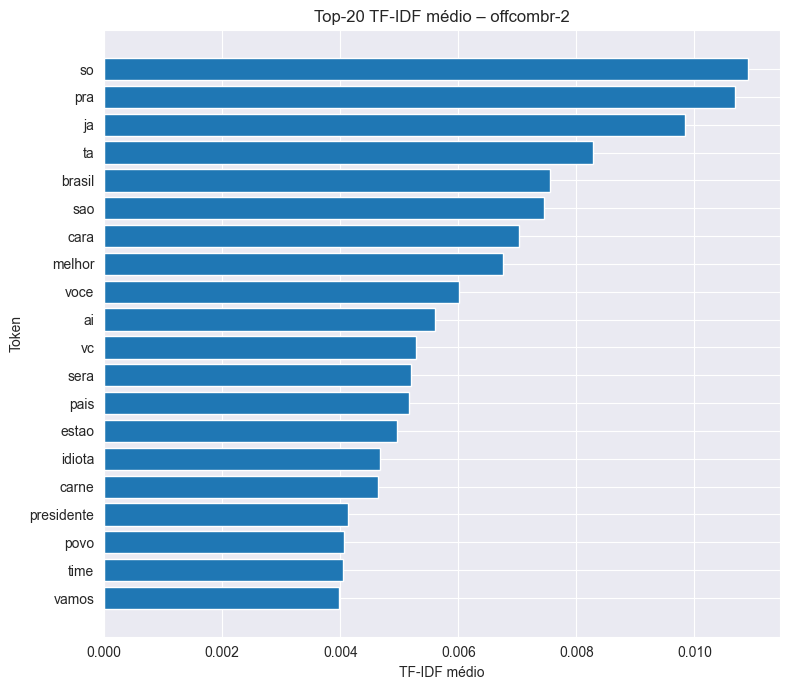


Palavras mais frequentes (tokenização PT - amostra):
so            75
pra           72
ja            64
ta            47
sao           46
brasil        44
melhor        31
cara          31
pais          28
ai            26
carne         26
estao         25
voce          25
politicos     24
ate           24
sera          23
vc            22
povo          22
dinheiro      21
vamos         19
ficar         18
temer         18
pro           17
propria       17
presidente    16
bosta         16
entao         15
ne            15
pec           15
boca          14

Distribuição de sentenças (PT - amostra):
count    1000.000000
mean        0.987000
std         0.113331
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000

Visualização 2D do TF-IDF (treino):


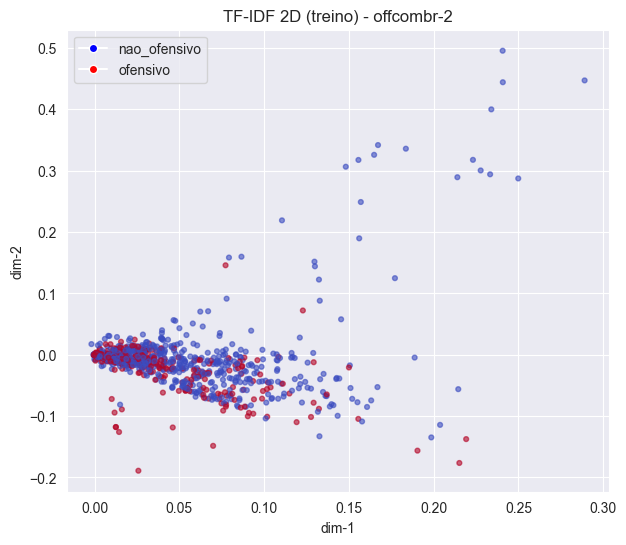


=== Exploração TF-IDF (offcombr-3) ===


,token,tfidf_mean
0,so,0.011498
1,pra,0.011259
2,ja,0.010131
3,ta,0.009005
4,brasil,0.008703
5,sao,0.008319
6,cara,0.007743
7,melhor,0.007580
8,voce,0.006251
9,sera,0.006043


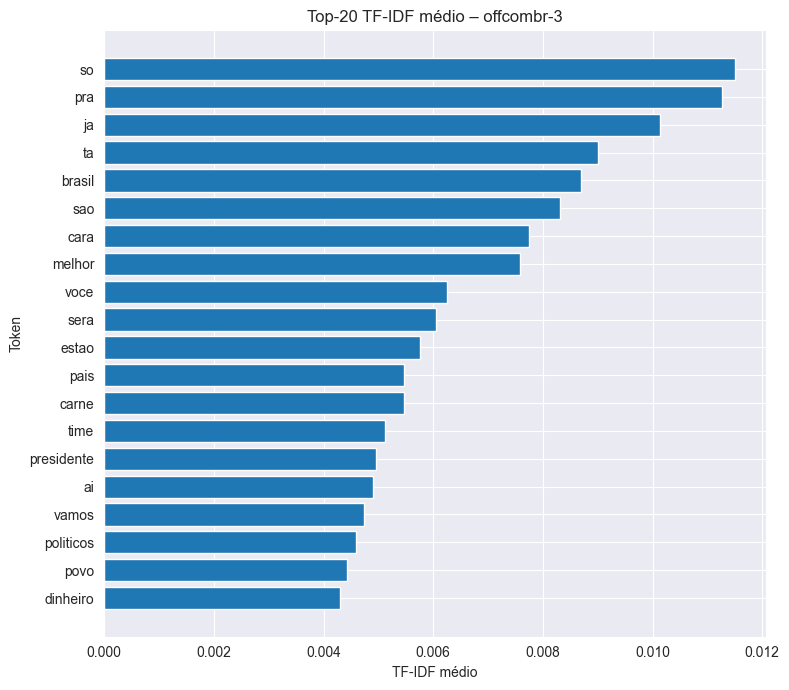


Palavras mais frequentes (tokenização PT - amostra):
so            65
pra           62
ja            57
sao           44
brasil        42
ta            42
melhor        29
cara          27
carne         25
estao         24
pais          24
politicos     23
voce          22
sera          22
ate           21
ai            19
dinheiro      19
povo          19
vamos         19
propria       16
presidente    16
temer         16
pec           15
vc            14
governo       14
time          13
ficar         13
entao         13
cortar        12
problema      12

Distribuição de sentenças (PT - amostra):
count    826.000000
mean       0.989104
std        0.103876
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000

Visualização 2D do TF-IDF (treino):


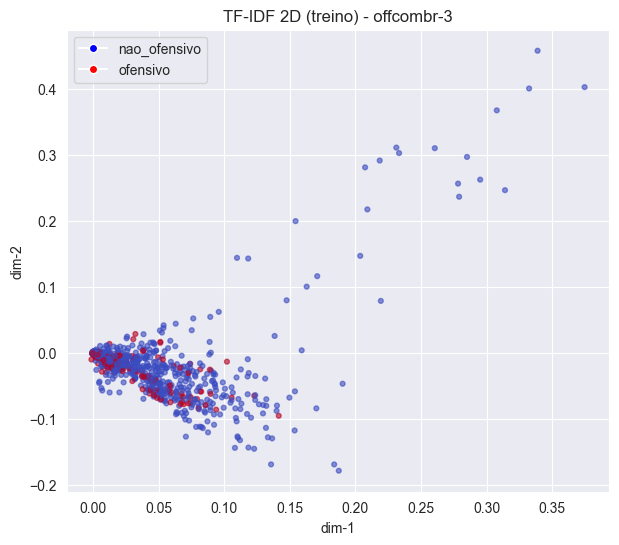

In [8]:
def build_tfidf(texts, max_features=MAX_FEATURES_TFIDF, ngram_range=(1,1), analyzer="word"):
    """ Cria e ajusta um TfidfVectorizer parametrizável por n-grams/analyzer.
    - texts: array de textos (pré-processados) do conjunto de treino
    - max_features: limite superior de vocabulário (controle de sparsidade/tempo)
    - ngram_range: tupla (min,max), ex: (1,2)
    - analyzer: 'word' ou 'char'
    Retorna:
      vec -> o vectorizer ajustado (fit) no treino
      X   -> a matriz TF-IDF esparsa [n_docs, n_features]"""
    vec = TfidfVectorizer(ngram_range=ngram_range, analyzer=analyzer, max_features=max_features)
    X = vec.fit_transform(texts)
    return vec, X

def top_tokens_by_tfidf(vec, X, top_k=30):
    """ Calcula a importância média dos tokens no corpus de treino:
      - média da coluna TF-IDF (quanto maior, mais representativo no corpus)
    Retorna um DataFrame com os TOP-K tokens e seu TF-IDF médio."""
    mean_vals = X.mean(axis=0).A1
    idx = np.argsort(mean_vals)[::-1][:top_k]
    feats = np.array(vec.get_feature_names_out())[idx]
    vals = mean_vals[idx]
    return pd.DataFrame({"token": feats, "tfidf_mean": vals})

def token_distribution_pt(texts, n=2000):
    """ Faz uma amostra (até n textos) e tokeniza em PT para ver as palavras
    mais frequentes (apenas para INSPEÇÃO; não é a base do modelo)."""
    sample = texts if len(texts) <= n else random.sample(list(texts), n)
    toks = []
    for t in sample:
        toks.extend(word_tokenize(t, language='portuguese'))
    return pd.Series(toks).value_counts().head(30)

def sentence_distribution_pt(texts, n=2000):
    """ Mede a distribuição de número de sentenças por documento (amostra até n),
    usando sent_tokenize em PT. Mostra o comprimento dos textos."""
    sample = texts if len(texts) <= n else random.sample(list(texts), n)
    sent_lens = [len(sent_tokenize(t, language='portuguese')) for t in sample]
    return pd.Series(sent_lens).describe()

def plot_tfidf_2d(X, labels, title="TF-IDF 2D (treino)"):
    """ Reduz a matriz TF-IDF de alta dimensão para 2D e plota:
      - Se UMAP estiver disponível, usa UMAP (mais expressivo).
      - Caso contrário, usa TruncatedSVD (rápido e estável em TF-IDF).
    'labels' são as classes 0/1 para colorir os pontos."""
    if X.shape[1] < 2:
        print("Matriz TF-IDF tem menos de 2 dimensões após seleção de features.")
        return
    if HAS_UMAP:
        reducer = umap.UMAP(random_state=SEED, n_components=2)
        X2 = reducer.fit_transform(X)
    else:
        svd = TruncatedSVD(n_components=2, random_state=SEED)
        X2 = svd.fit_transform(X)

    plt.figure(figsize=(7,6))
    plt.scatter(X2[:,0], X2[:,1], c=labels, cmap="coolwarm", alpha=0.6, s=12)
    plt.title(title)
    plt.xlabel("dim-1"); plt.ylabel("dim-2")
    # Legenda simples: 0=nao_ofensivo, 1=ofensivo
    handles = [plt.Line2D([0],[0], marker='o', color='w', label='nao_ofensivo',
                          markerfacecolor='blue', markersize=6),
               plt.Line2D([0],[0], marker='o', color='w', label='ofensivo',
                          markerfacecolor='red', markersize=6)]
    plt.legend(handles=handles, loc="best")
    plt.show()

def plot_top_tokens_bar(df_top, top_n=20, title="Top tokens por TF-IDF médio"):
    """ Plota um gráfico de barras horizontal com os 'top_n' tokens de maior TF-IDF médio.
    - df_top: DataFrame com colunas ['token', 'tfidf_mean'] (saída de top_tokens_by_tfidf)
    - top_n: quantos tokens exibir"""
    # Seleciona os top_n (se df_top tiver < top_n, pega todos)
    df_show = df_top.head(top_n).copy()

    # Inverte a ordem para o barh (o maior em cima)
    df_show = df_show.iloc[::-1]

    plt.figure(figsize=(8, max(4, top_n * 0.35)))
    plt.barh(df_show["token"], df_show["tfidf_mean"])
    plt.title(title)
    plt.xlabel("TF-IDF médio")
    plt.ylabel("Token")
    plt.tight_layout()
    plt.show()

# Execução da exploração para cada variante (OFFCOMBR-2 e OFFCOMBR-3)
# Usa os textos PRÉ-PROCESSADOS do CONJUNTO DE TREINO (splits[cfg]["train_text"])
for cfg in CONFIGS:
    print(f"\n=== Exploração TF-IDF ({cfg}) ===")
    tr_texts = splits[cfg]["train_text"]    # Textos já pré-processados (tokenização, stopwords, stemming, unigramas)
    tr_y = splits[cfg]["train_y"]           # Rótulos 0/1

    # Vetorização TF-IDF no treino (define vocabulário e pesos) — usa n-grams do config
    vec, Xtr = build_tfidf(tr_texts, ngram_range=TFIDF_EXPLORE_NGRAMS, analyzer="word")

    # Top-K tokens por TF-IDF médio (importância média no corpus)
    df_top = top_tokens_by_tfidf(vec, Xtr, top_k=30)
    display(df_top)

    # Gráfico de barras com os 20 principais tokens por TF-IDF médio
    plot_top_tokens_bar(df_top, top_n=20, title=f"Top-20 TF-IDF médio – {cfg}")

    # Distribuição de tokens (amostra) com tokenização PT (diagnóstico)
    print("\nPalavras mais frequentes (tokenização PT - amostra):")
    print(token_distribution_pt(tr_texts).to_string())

    # Distribuição do número de sentenças por documento (amostra)
    print("\nDistribuição de sentenças (PT - amostra):")
    print(sentence_distribution_pt(tr_texts).to_string())

    # Visualização 2D do espaço TF-IDF do treino
    print("\nVisualização 2D do TF-IDF (treino):")
    plot_tfidf_2d(Xtr, tr_y, title=f"TF-IDF 2D (treino) - {cfg}")

## 4. Modelo Random Forest (TF‑IDF) + SHAP



=== Random Forest @ offcombr-2 (word1-2 + char3-5) ===
              precision    recall  f1-score   support

nao_ofensivo     0.8031    0.9337    0.8635       166
    ofensivo     0.8070    0.5476    0.6525        84

    accuracy                         0.8040       250
   macro avg     0.8051    0.7407    0.7580       250
weighted avg     0.8044    0.8040    0.7926       250

Matriz de confusão (linhas=verdadeiro, colunas=previsto):


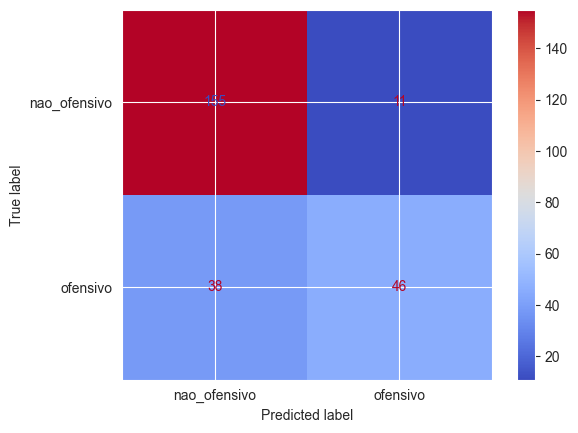


Instâncias mal classificadas (exibindo até 10): 49
- TRUE=1 PRED=0 | flam aproveita juiz bandeirinhas profissional
- TRUE=0 PRED=1 | prefere usar damiao vizeu comentarios
- TRUE=1 PRED=0 | comunista defendendo democraciakkkkk vermelhinhos sao piada
- TRUE=1 PRED=0 | roberto adora palavra acefalo ouvir incorporou vocabulario pobre inculto
- TRUE=1 PRED=0 | sera hospedou mansao dedos punta del
- TRUE=1 PRED=0 | concordo carlos lavagem cerebral pra asnos
- TRUE=1 PRED=0 | mulambos passam fase liberta viver vera vao ficar so cheirin frameigo clube cheiroso brasil kkkkk
- TRUE=0 PRED=1 | intao vc ganhar nd pk ruim msm
- TRUE=1 PRED=0 | felizmente extirpamos projeto defoder povo cleptorrupto
- TRUE=1 PRED=0 | voces sao idiotas executivo interfira poderes salarios vinculados texto constitucional informem santo pra passarem vergonha falar

=== Random Forest @ offcombr-3 (word1-2 + char3-5) ===
              precision    recall  f1-score   support

nao_ofensivo     0.8300    0.9940    0.9046  

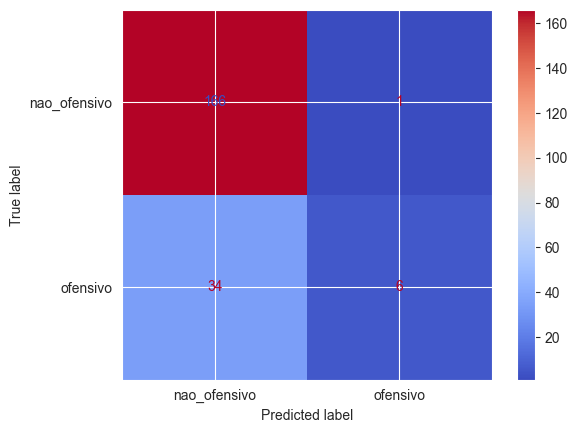


Instâncias mal classificadas (exibindo até 10): 35
- TRUE=1 PRED=0 | corrupta terrorista apresenta ameaca honesto povo uruguaio
- TRUE=1 PRED=0 | gentinha estao fedendo mortadela podre tomam banho
- TRUE=1 PRED=0 | cuidar bandida venda infirmacoes sensiveis brasil
- TRUE=1 PRED=0 | retocar maquiagem tricolete frufru come ninguem comido
- TRUE=1 PRED=0 | igual mamis prega indestrutivel kkkkkkkkkkk
- TRUE=1 PRED=0 | junior soares defequei juniorizinhos
- TRUE=1 PRED=0 | ja programa
- TRUE=1 PRED=0 | adinaldo kkkkkkkkkkkk defe cando mortadela
- TRUE=1 PRED=0 | mulher pia fogao cama
- TRUE=1 PRED=0 | kkkkk ladrao merece morte


In [9]:
from sklearn.pipeline import FeatureUnion

def train_eval_rf(cfg, n_estimators=600, max_depth=None):
    tr_texts, tr_y = splits[cfg]["train_text"], splits[cfg]["train_y"]
    te_texts, te_y = splits[cfg]["test_text"], splits[cfg]["test_y"]

    feats = FeatureUnion([
        ("word", TfidfVectorizer(ngram_range=(1,2), analyzer="word", max_features=MAX_FEATURES_TFIDF)),
        ("char", TfidfVectorizer(ngram_range=(3,5), analyzer="char", max_features=MAX_FEATURES_TFIDF))
    ])

    pipe = Pipeline([
        ("feats", feats),
        ("rf", RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                     class_weight="balanced_subsample", n_jobs=-1, random_state=SEED))
    ])
    pipe.fit(tr_texts, tr_y)

    # predictions and probabilities
    te_pred = pipe.predict(te_texts)
    acc = accuracy_score(te_y, te_pred)
    p, r, f1, _ = precision_recall_fscore_support(te_y, te_pred, average="macro", zero_division=0)

    print(f"\n=== Random Forest @ {cfg} (word1-2 + char3-5) ===")
    print(classification_report(te_y, te_pred, digits=4, target_names=["nao_ofensivo","ofensivo"]))
    print("Matriz de confusão (linhas=verdadeiro, colunas=previsto):")
    cm = confusion_matrix(te_y, te_pred, labels=[0,1])
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["nao_ofensivo","ofensivo"])
    cm_display.plot(cmap="coolwarm", values_format="d")
    plt.show()

    # misclassified
    mis_idx = np.where(te_pred != te_y)[0].tolist()
    print(f"\nInstâncias mal classificadas (exibindo até 10): {len(mis_idx)}")
    for i in mis_idx[:10]:
        print(f"- TRUE={te_y[i]} PRED={te_pred[i]} | {te_texts[i][:200]}")

    return pipe, {"accuracy":acc,"precision_macro":p,"recall_macro":r,"f1_macro":f1}

rf_pipes = {}
rf_metrics = {}
for cfg in CONFIGS:
    pipe, mets = train_eval_rf(cfg)
    rf_pipes[cfg] = pipe
    rf_metrics[cfg] = mets

### 4.1 SHAP no RF (global e local)



=== SHAP para RF (offcombr-2) ===


100%|===================| 398/400 [03:51<00:01]        

[debug] n_vec=28163 | n_shap=28163 | n_common=28163 | X_eval=(200, 28163)


,token,mean_abs_shap
0,char__sre,0.005286
1,char__sras,0.005286
2,char__saque,0.005047
3,char__saqu,0.005047
4,char__silva,0.004220
5,char__silv,0.004220
6,char__vc le,0.003700
7,char__vc l,0.003700
8,char__oce c,0.003488
9,char__oce d,0.003488


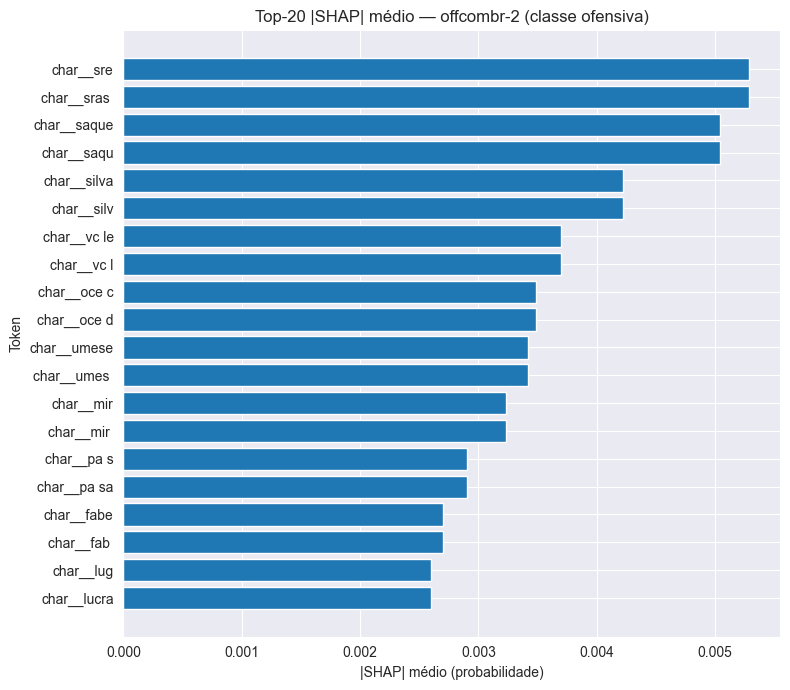

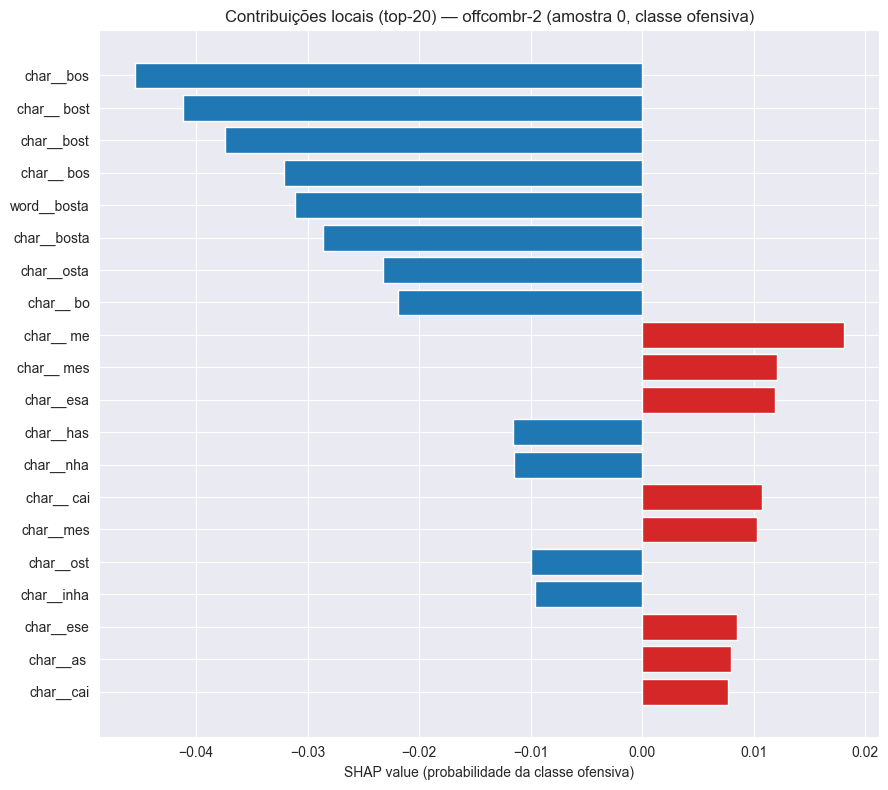


=== SHAP para RF (offcombr-3) ===


100%|===================| 398/400 [02:37<00:00]        

[debug] n_vec=27019 | n_shap=27019 | n_common=27019 | X_eval=(200, 27019)


,token,mean_abs_shap
0,char__desco,0.003146
1,char__desca,0.003146
2,char__m ho,0.003012
3,char__m h,0.003012
4,char__nomia,0.003012
5,char__nomic,0.003012
6,char__solu,0.002737
7,char__solta,0.002737
8,char__marg,0.002720
9,char__marco,0.002720


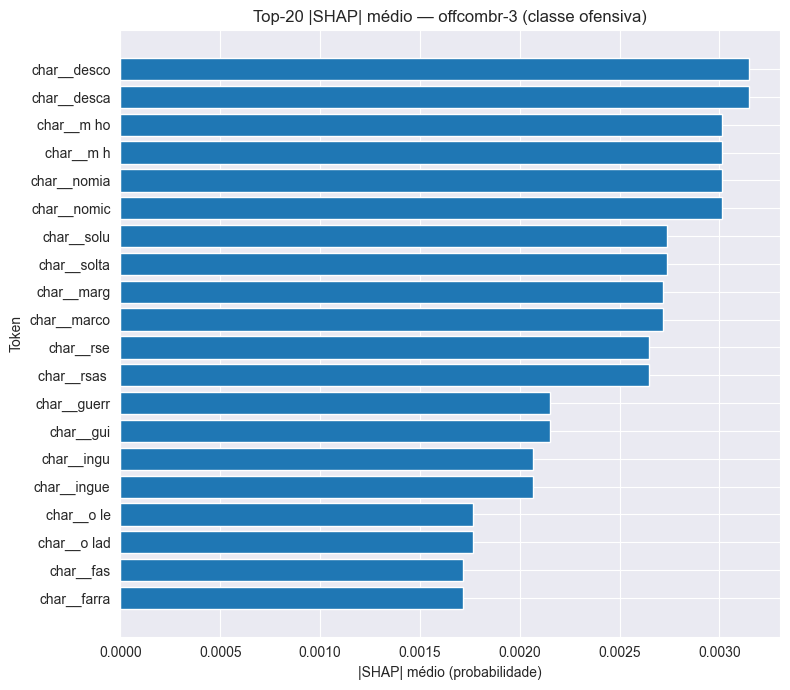

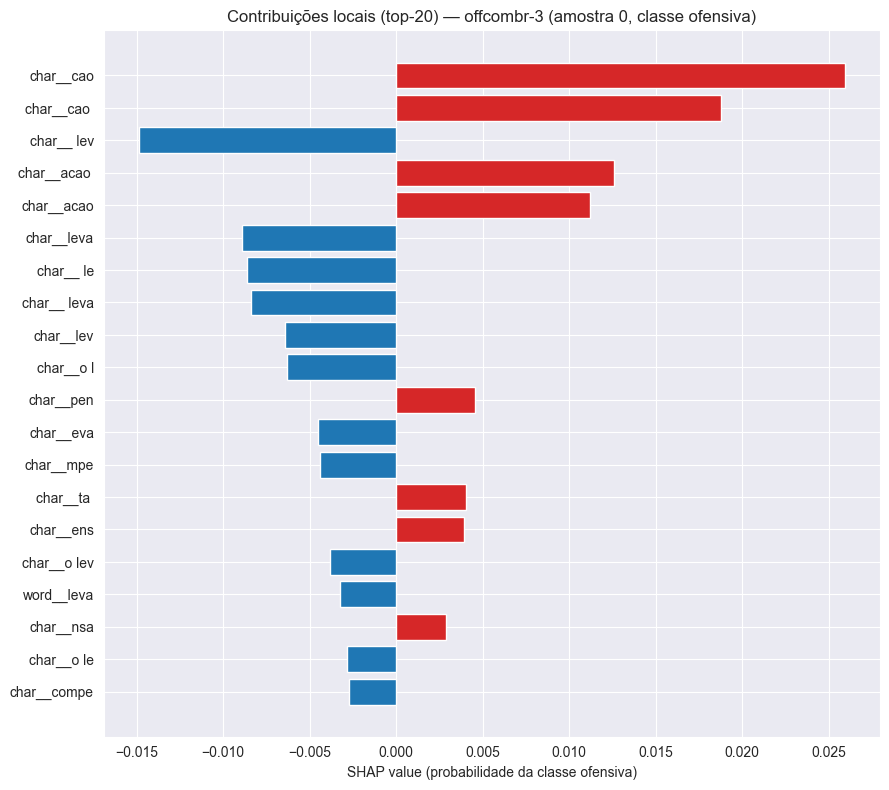

In [10]:
def shap_rf_global_local(pipe, cfg, max_bg=300, max_eval=200, top_k=20, show_bar=True, show_local=True, verbose_once=True):
    """ SHAP para RF (TF-IDF) com alinhamento robusto.
    - Global: top-|SHAP| médio (classe positiva) + barh
    - Local: top-|SHAP| da 1ª amostra do conjunto de avaliação + barh manual (sinal e magnitude)"""
    vec = pipe.named_steps["feats"] if "feats" in pipe.named_steps else pipe.named_steps["tfidf"]
    rf  = pipe.named_steps["rf"]
    tr_texts = splits[cfg]["train_text"]
    te_texts = splits[cfg]["test_text"]
    rng = np.random.default_rng(SEED)

    # ----- Background (treino) e Avaliação (teste) -----
    bg_idx = rng.choice(len(tr_texts), size=min(max_bg, len(tr_texts)), replace=False)
    ev_idx = rng.choice(len(te_texts), size=min(max_eval, len(te_texts)), replace=False)
    X_bg   = vec.transform(tr_texts[bg_idx]).toarray()
    X_eval = vec.transform(te_texts[ev_idx]).toarray()
    feature_names_full = np.asarray(vec.get_feature_names_out())
    n_vec = feature_names_full.shape[0]
    assert X_bg.shape[1] == n_vec and X_eval.shape[1] == n_vec, "Desalinhamento TF-IDF vs nomes."

    # ----- Explainer (interventional + probability) -----
    explainer = shap.TreeExplainer(rf, data=X_bg, model_output="probability", feature_perturbation="interventional")
    sv = explainer.shap_values(X_eval)

    # Converte p/ ndarray
    shap_pos_arr = np.asarray(sv[1] if isinstance(sv, list) else sv)    # (n_eval, n_features) idealmente
    if shap_pos_arr.ndim == 1:
        shap_pos_arr = shap_pos_arr.reshape(1, -1)
    n_shap = shap_pos_arr.shape[1]
    n_common = min(n_vec, n_shap)
    if verbose_once:
        print(f"[debug] n_vec={n_vec} | n_shap={n_shap} | n_common={n_common} | X_eval={X_eval.shape}")
    feature_names = feature_names_full[:n_common]
    shap_pos_arr  = shap_pos_arr[:, :n_common]

    # ===================== GLOBAL =====================
    mean_abs = np.mean(np.abs(shap_pos_arr), axis=0).ravel()[:n_common]
    k_global = min(top_k, n_common)
    order = np.argsort(mean_abs)[::-1][:k_global].astype(int)
    feats = feature_names[order]; vals = mean_abs[order]
    df_top = pd.DataFrame({"token": feats.tolist(), "mean_abs_shap": vals.tolist()})
    display(df_top)
    if show_bar:
        df_show = df_top.iloc[::-1]
        plt.figure(figsize=(8, max(4, len(df_show) * 0.35)))
        plt.barh(df_show["token"], df_show["mean_abs_shap"])
        plt.title(f"Top-{k_global} |SHAP| médio — {cfg} (classe ofensiva)")
        plt.xlabel("|SHAP| médio (probabilidade)")
        plt.ylabel("Token")
        plt.tight_layout()
        plt.show()

    # ===================== LOCAL (barh manual) =====================
    if show_local and shap_pos_arr.shape[0] > 0:
        # Contribuições da 1ª amostra
        local_full = shap_pos_arr[0, :n_common]

        # Normalização: força cada elemento a ser escalar float
        def _to_scalar(x):
            arr = np.asarray(x)
            return float(arr.reshape(-1)[0])    # Pega o primeiro escalar caso venha vetor/array

        local_full = np.array([_to_scalar(v) for v in local_full], dtype=float) # (m_names,)
        k_local = min(top_k, n_common)
        idx_loc = np.argsort(np.abs(local_full))[::-1][:k_local].astype(int)
        local_vals  = local_full[idx_loc]; local_names = feature_names[idx_loc]

        # Plot barh com sinal (positivo empurra para ofensivo; negativo contra)
        order_plot = np.argsort(np.abs(local_vals))[::-1]
        vals_plot  = local_vals[order_plot]
        names_plot = local_names[order_plot]
        plt.figure(figsize=(9, max(4, k_local * 0.4)))
        colors = ["tab:red" if v > 0 else "tab:blue" for v in vals_plot]
        plt.barh(range(len(vals_plot)), vals_plot, color=colors)
        plt.yticks(range(len(vals_plot)), names_plot)
        plt.title(f"Contribuições locais (top-{k_local}) — {cfg} (amostra 0, classe ofensiva)")
        plt.xlabel("SHAP value (probabilidade da classe ofensiva)")
        plt.gca().invert_yaxis()    # maior no topo
        plt.tight_layout()
        plt.show()

for cfg in CONFIGS:
    print(f"\n=== SHAP para RF ({cfg}) ===")
    shap_rf_global_local(rf_pipes[cfg], cfg)

## 5. BERTimbau (Transformer) + SHAP


torch: 2.9.0+cu126 | cuda disponível: True
GPU: NVIDIA GeForce RTX 3080 Laptop GPU | cc: (8, 6)

=== Fine-tuning BERTimbau (offcombr-2) ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.581400,0.458820,0.784000,0.769904,0.725617,0.738797
2,0.375800,0.432584,0.796000,0.797436,0.728772,0.745910
3,0.233900,0.371718,0.844000,0.823609,0.832544,0.827650



=== Avaliação BERTimbau (offcombr-2) ===
eval_loss = 0.37171801924705505
eval_accuracy = 0.844
eval_precision_macro = 0.8236094633261218
eval_recall_macro = 0.8325444635685599
eval_f1_macro = 0.8276502094712839
eval_runtime = 30.1255
eval_samples_per_second = 8.299
eval_steps_per_second = 0.266
epoch = 3.0

Classification report:
              precision    recall  f1-score   support

nao_ofensivo     0.8944    0.8675    0.8807       166
    ofensivo     0.7528    0.7976    0.7746        84

    accuracy                         0.8440       250
   macro avg     0.8236    0.8325    0.8277       250
weighted avg     0.8468    0.8440    0.8451       250

Average Precision (PR-AUC) = 0.7714
Matriz de confusão (linhas=verdadeiro, colunas=previsto):


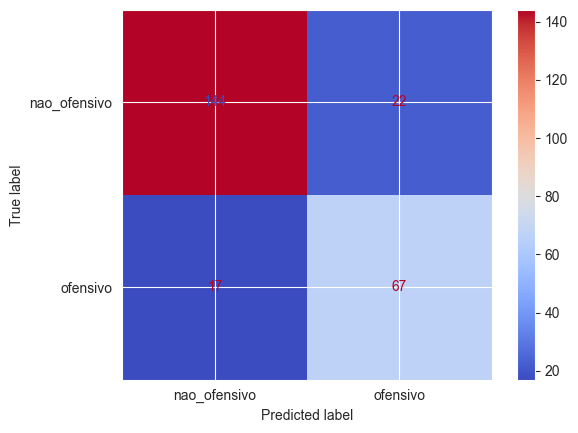


Instâncias mal classificadas (exibindo até 10): 39
- TRUE=1 PRED=0 | O flaM E R D A vai aproveita o JUIZ e os BANDEIRINHAS no profissional em
- TRUE=0 PRED=1 | ROMARIOgtRONALDOgtZIDANEgtMESSIgtRONALDINHOgtCR
- TRUE=1 PRED=0 | Comunista defendendo a  Democraciakkkkk esses vermelhinhos sao uma piada
- TRUE=1 PRED=0 | Prefiro ver o Lula morto
- TRUE=1 PRED=0 | Mulambos  nao passam da primeira fase da liberta  Quem viver vera  Vao ficar so no cheirin De novo Frameigo o clube mais cheiroso do Brasil  Kkkkk
- TRUE=1 PRED=0 | Walter devia lutar SUMO PODERIA SE DAR BEM
- TRUE=0 PRED=1 | fafa e daqueles  alunos que eram zuados na escola por isso paga de revoltadinho na internet
- TRUE=0 PRED=1 | Ela ganhou um Oreo do  Tabare e num milenar ritual esquerdista esta oferecendo ao vento
- TRUE=0 PRED=1 | Collor nao e digno nem para limpar os sapatos  desta  DIVA
- TRUE=1 PRED=0 | Voces sao idiotas ou se fazem Voces sabem que ele e do executivo e quer que interfira nos outros poderes Esses salarios 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.527500,0.411214,0.806763,0.403382,0.500000,0.446524
2,0.341400,0.342417,0.845411,0.773342,0.666542,0.696481
3,0.210800,0.367415,0.864734,0.807374,0.716542,0.747649



=== Avaliação BERTimbau (offcombr-3) ===
eval_loss = 0.36741456389427185
eval_accuracy = 0.8647342995169082
eval_precision_macro = 0.8073735656608585
eval_recall_macro = 0.7165419161676647
eval_f1_macro = 0.7476489028213167
eval_runtime = 30.4359
eval_samples_per_second = 6.801
eval_steps_per_second = 0.23
epoch = 3.0

Classification report:
              precision    recall  f1-score   support

nao_ofensivo     0.8840    0.9581    0.9195       167
    ofensivo     0.7308    0.4750    0.5758        40

    accuracy                         0.8647       207
   macro avg     0.8074    0.7165    0.7476       207
weighted avg     0.8544    0.8647    0.8531       207

Average Precision (PR-AUC) = 0.6034
Matriz de confusão (linhas=verdadeiro, colunas=previsto):


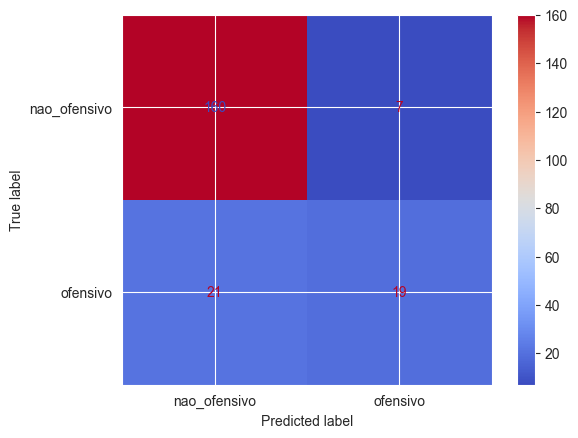


Instâncias mal classificadas (exibindo até 10): 28
- TRUE=1 PRED=0 | Essa corrupta terrorista apresenta uma ameaca ao honesto povo Uruguaio
- TRUE=0 PRED=1 | Boca mole e bolso e contas bancarias abarrotadas de dolares Sahfado
- TRUE=1 PRED=0 | Tem que cuidar para que esta bandida nao venda infirmacoes sensiveis do Brasil
- TRUE=1 PRED=0 | Vai retocar a maquiagem tricolete O frufru nao come ninguem ele e comido
- TRUE=0 PRED=1 | Essa  muie nem drome nem da cuie nem brinca em fiuvicoCuidado
- TRUE=1 PRED=0 | Nao Junior Soares Defequei uns juniorizinhos soares aqui
- TRUE=1 PRED=0 | Ja fez programa hoje
- TRUE=1 PRED=0 | KKKKK MAIOR LADRAO QUE MERECE A MORTE
- TRUE=1 PRED=0 | E so ver o numero de dislike de seu coment inutil e ver que nao tem tanta moral assimPalhaco
- TRUE=1 PRED=0 | Vc  deve ser retardado


In [11]:
# --- GPU/precisão: configurações
USE_GPU = torch.cuda.is_available()

# Ampere+ suporta bf16; caso    contrário, fp16
BF16_OK = USE_GPU and torch.cuda.get_device_capability(0)[0] >= 8
FP16_OK = USE_GPU and not BF16_OK

if USE_GPU:
    torch.set_float32_matmul_precision("high")
    torch.backends.cudnn.benchmark = True

def make_train_args(out_dir, *, epochs=3, bsz_train=16, bsz_eval=32, lr=2e-5, seed=42, warmup_ratio=0.1):
    """ Helper para criar TrainingArguments com os *flags* corretos para GPU/CPU."""
    return TrainingArguments(
        output_dir=out_dir,
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=bsz_train,
        per_device_eval_batch_size=bsz_eval,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        warmup_ratio=warmup_ratio,
        weight_decay=0.01,
        seed=seed,
        report_to="none",
        fp16=FP16_OK,
        bf16=BF16_OK,
        gradient_accumulation_steps=1,
        dataloader_num_workers=2,
        dataloader_pin_memory=USE_GPU,
    )

def tokenize_ds(tokenizer, texts, labels, max_length=MAX_LEN_BERT):
    """ Tokeniza sem padding fixo (padding dinâmico será feito pelo DataCollator)."""
    enc = tokenizer(list(texts), truncation=True, padding=False, max_length=max_length)
    enc["labels"] = list(labels)
    return enc

def run_bertimbau(
    cfg,
    model_name="neuralmind/bert-base-portuguese-cased",
    lr=LR_BERT, epochs=EPOCHS_BERT,
    bsz_train=BATCH_TRAIN, bsz_eval=BATCH_EVAL,
    max_length=MAX_LEN_BERT
):
    # --- Dados (mesmo split da Seção 2.1) — usa texto bruto quando disponível para Transformers
    tr_texts = splits[cfg]["train_text_raw"] if "train_text_raw" in splits[cfg] else splits[cfg]["train_text"]
    tr_y     = splits[cfg]["train_y"]
    te_texts = splits[cfg]["test_text_raw"] if "test_text_raw" in splits[cfg] else splits[cfg]["test_text"]
    te_y     = splits[cfg]["test_y"]

    # --- Tokenizer + datasets HF
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_enc = tokenize_ds(tokenizer, tr_texts, tr_y, max_length=max_length)
    test_enc  = tokenize_ds(tokenizer, te_texts, te_y,  max_length=max_length)

    train_ds = hfds.Dataset.from_dict(train_enc)
    test_ds  = hfds.Dataset.from_dict(test_enc)

    # Padding dinâmico, múltiplo de 8 acelera GPU
    collator = DataCollatorWithPadding(
        tokenizer=tokenizer,
        pad_to_multiple_of=8 if USE_GPU else None
    )

    # --- Modelo
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # --- Args de treino (com fp16/bf16 quando possível)
    args = make_train_args(
        out_dir=os.path.join(ARTIFACTS_DIR, f"hf_{model_name.split('/')[-1]}_{cfg}"),
        epochs=epochs, bsz_train=bsz_train, bsz_eval=bsz_eval, lr=lr, seed=SEED
    )

    # --- Métricas
    metric_acc = evaluate.load("accuracy")
    metric_f1  = evaluate.load("f1")
    metric_pr  = evaluate.load("precision")
    metric_rc  = evaluate.load("recall")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy":  metric_acc.compute(predictions=preds, references=labels)["accuracy"],
            "precision_macro": metric_pr.compute(predictions=preds, references=labels, average="macro")["precision"],
            "recall_macro":    metric_rc.compute(predictions=preds, references=labels, average="macro")["recall"],
            "f1_macro":        metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
        }

    # --- Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    # --- Treino + avaliação
    trainer.train()
    metrics = trainer.evaluate()
    print(f"\n=== Avaliação BERTimbau ({cfg}) ===")
    for k, v in metrics.items():
        print(k, "=", v)

    # --- Inferência no teste para relatório/CM/erros
    raw = trainer.predict(test_ds)
    preds = np.argmax(raw.predictions, axis=-1)

    print("\nClassification report:")
    print(classification_report(te_y, preds, digits=4, target_names=["nao_ofensivo","ofensivo"]))
    
    # PR-AUC (AP) rápido para referência
    try:
        y_score = torch.softmax(torch.tensor(raw.predictions), dim=-1)[:,1].numpy()
        ap = average_precision_score(te_y, y_score)
        print(f"Average Precision (PR-AUC) = {ap:.4f}")
    except Exception:
        pass

    print("Matriz de confusão (linhas=verdadeiro, colunas=previsto):")
    cm = confusion_matrix(te_y, preds, labels=[0,1])
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["nao_ofensivo","ofensivo"])
    cm_display.plot(cmap="coolwarm", values_format="d")
    plt.show()

    mis_idx = np.where(preds != te_y)[0].tolist()
    print(f"\nInstâncias mal classificadas (exibindo até 10): {len(mis_idx)}")
    for i in mis_idx[:10]:
        print(f"- TRUE={te_y[i]} PRED={preds[i]} | {te_texts[i][:200]}")

    return tokenizer, model

# --------------------------
# Execução (OFFCOMBR-2/3)
# --------------------------
print("torch:", torch.__version__, "| cuda disponível:", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print("GPU:", torch.cuda.get_device_name(0), "| cc:", torch.cuda.get_device_capability(0))
    except Exception:
        pass

bert_tok = {}
bert_model = {}
for cfg in CONFIGS:
    print(f"\n=== Fine-tuning BERTimbau ({cfg}) ===")
    tok, mdl = run_bertimbau(cfg)
    bert_tok[cfg] = tok
    bert_model[cfg] = mdl

### 5.1 SHAP no BERTimbau (masker de texto)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



=== SHAP: BERTimbau (offcombr-2) ===
Using 250 test texts from splits[offcombr-2]['test_text'].
Running SHAP on 100 texts...


PartitionExplainer explainer: 101it [03:15,  1.96s/it]                         


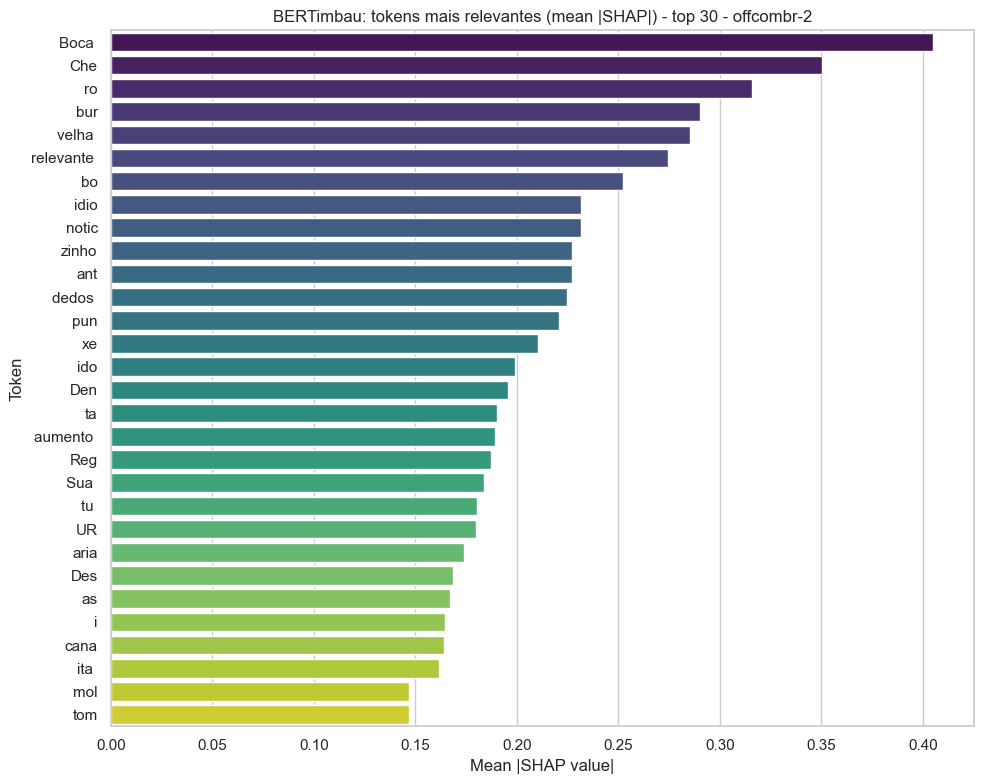

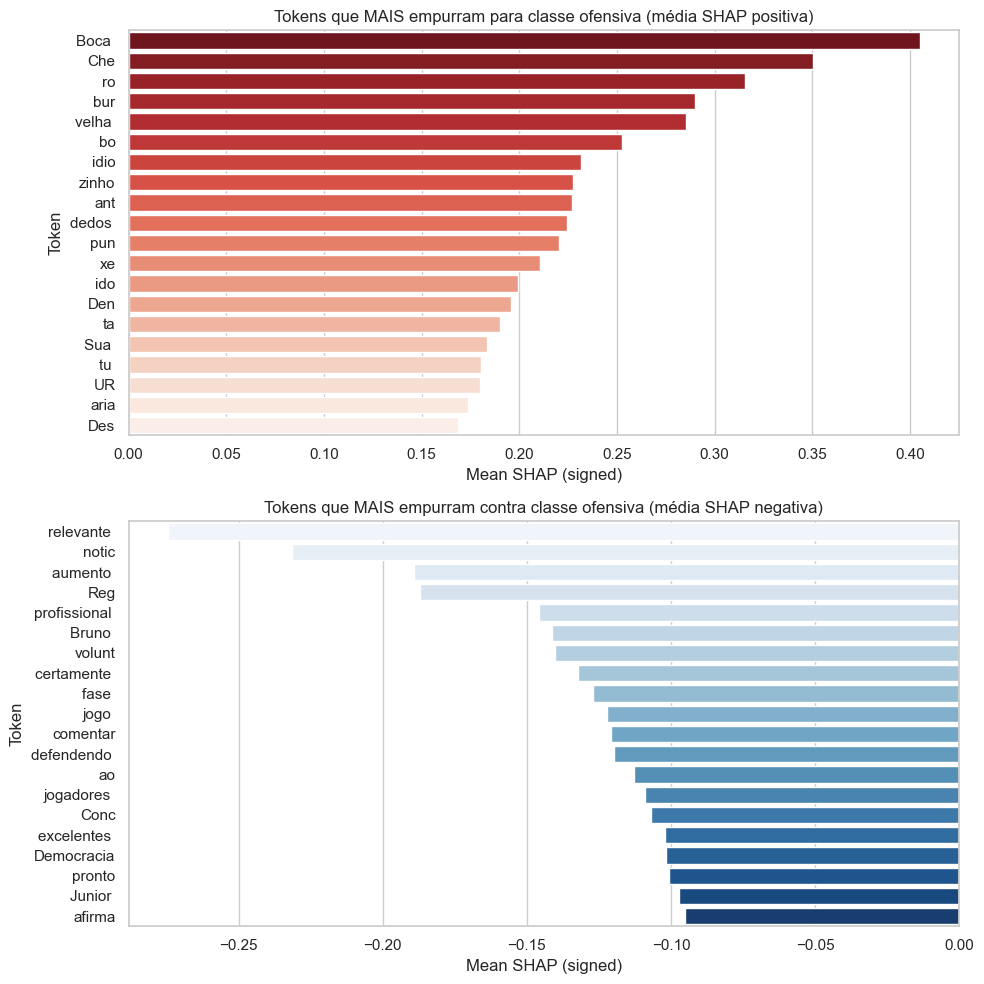

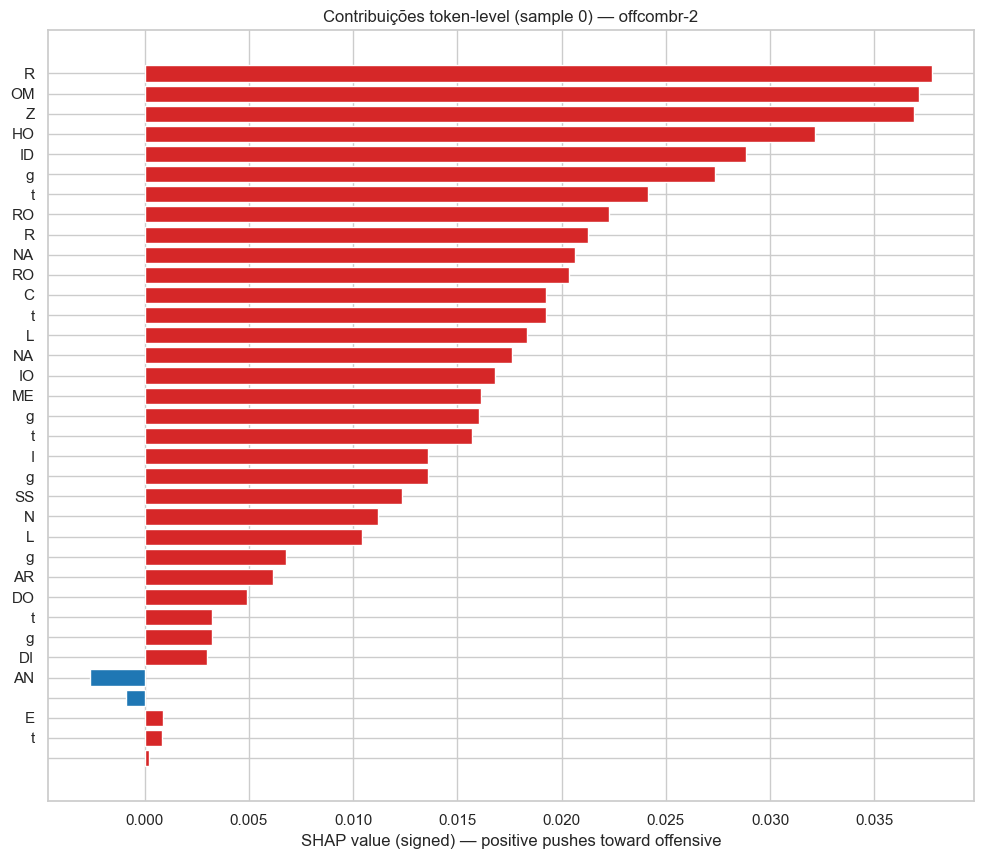

Sample 0 text (preprocessed): ROMARIOgtRONALDOgtZIDANEgtMESSIgtRONALDINHOgtCR


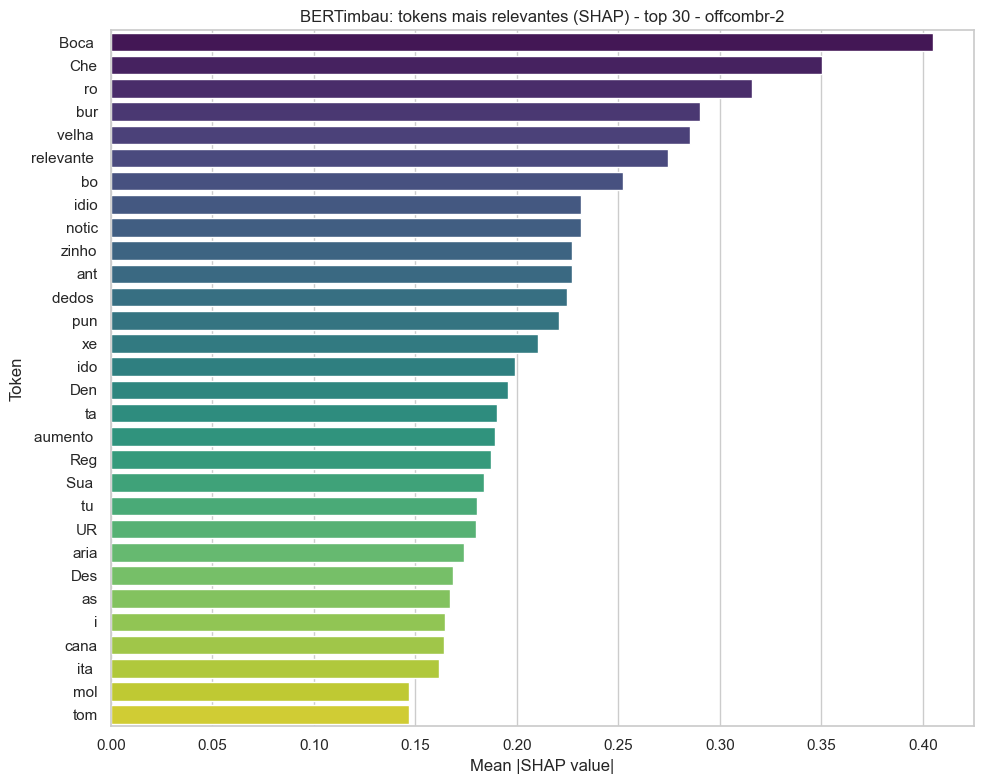

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



=== SHAP: BERTimbau (offcombr-3) ===
Using 207 test texts from splits[offcombr-3]['test_text'].
Running SHAP on 90 texts...


PartitionExplainer explainer: 91it [02:36,  1.82s/it]                        


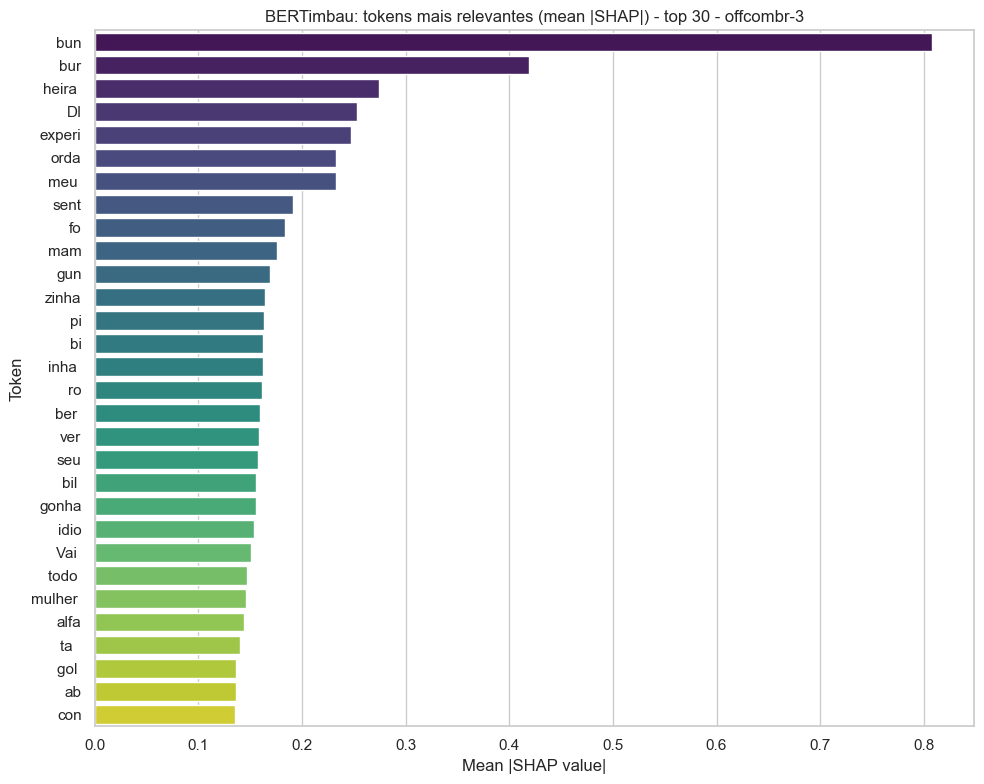

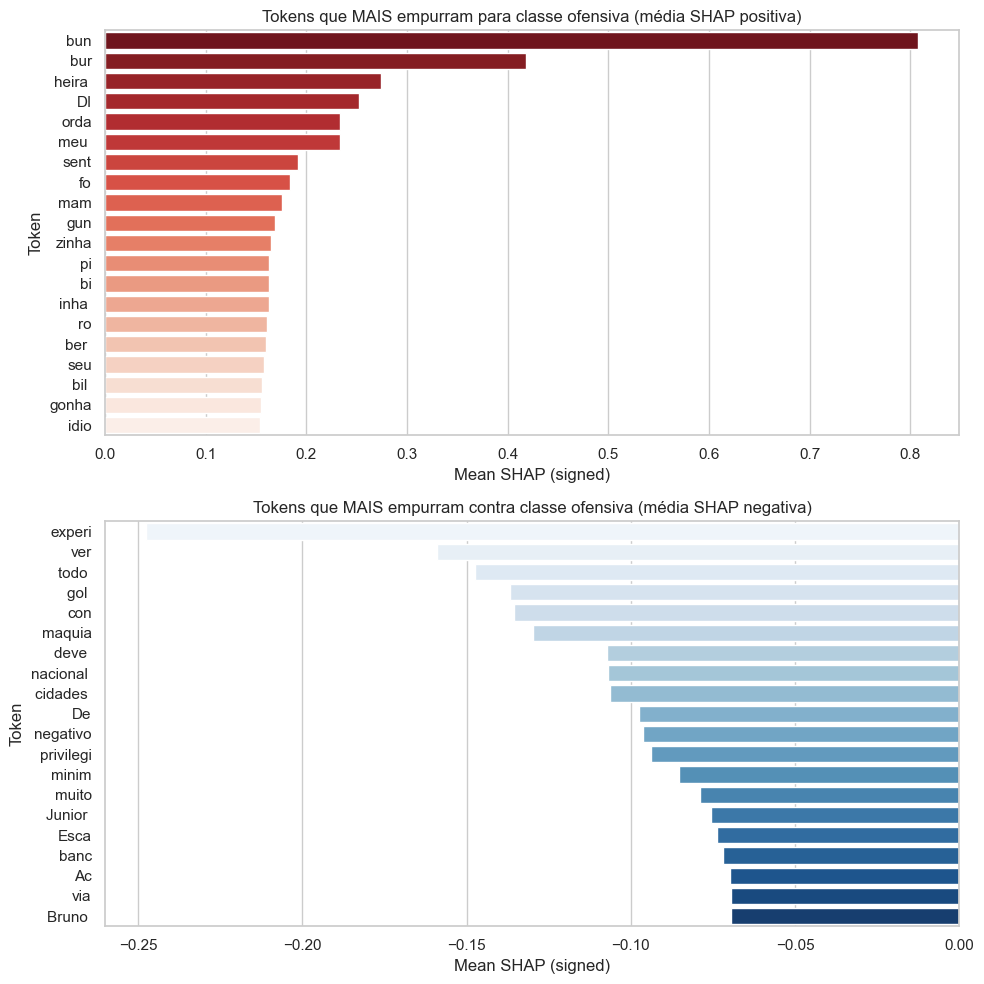

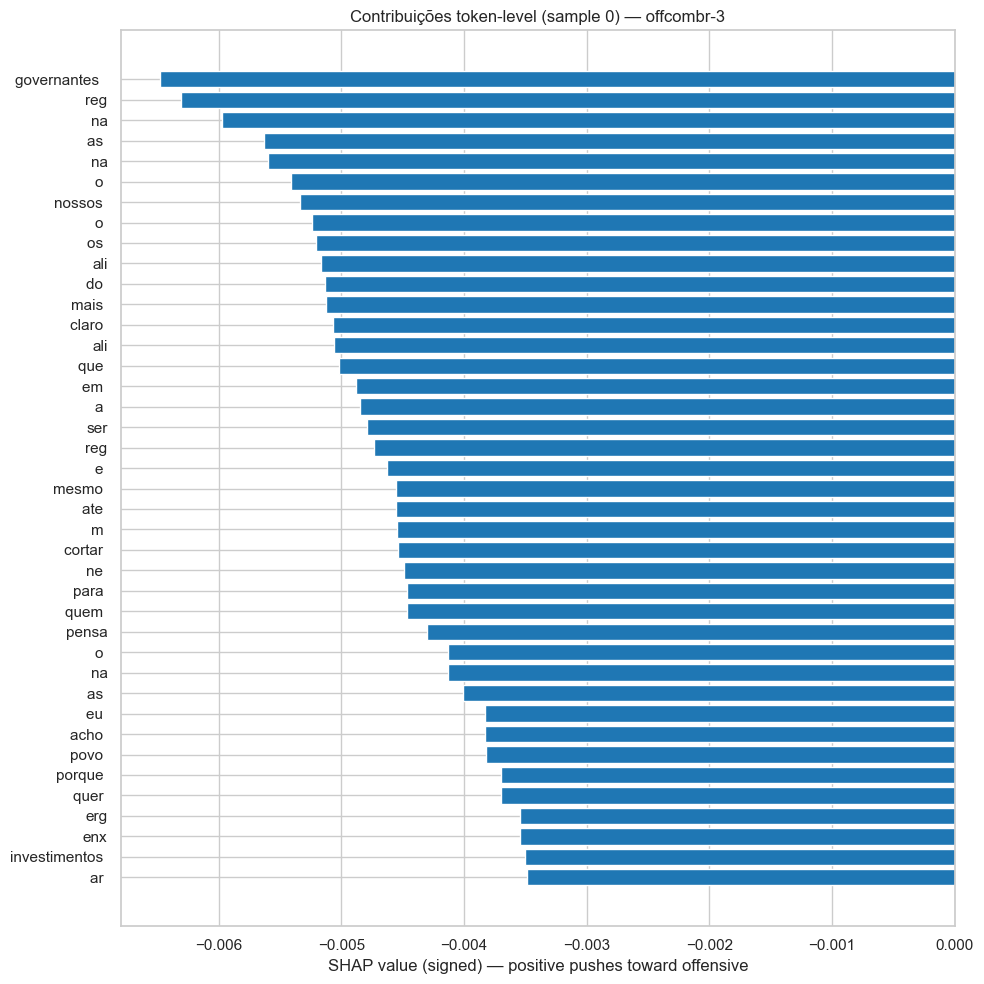

Sample 0 text (preprocessed): Sabe o que eu acho engracado os nossos governantes  nao pensam em cortar regalias e beneficios desnecessarios que os favorecem porque sera ne e mais do que claro ate mesmo para quem nao quer enxergar eles sao estao la para defender seus proprios interesses  e os dos empresario o no casso eles tambem ou comecamos a tomar uma atitude para mudar de uma vez por todas essa roubalheira nesse pais o a tendencia e so piorar para o povo porque dinheiro para investimentos nao tem mais para aumentos de salario e regalias nao falta


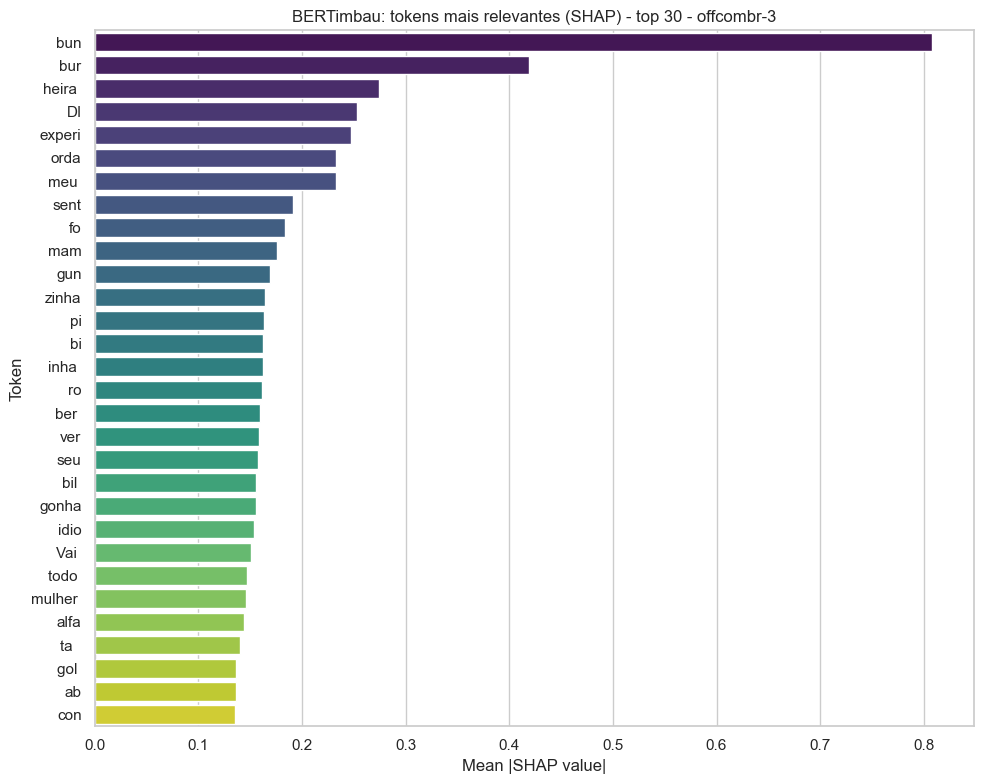

In [12]:
# --------------------------
# SHAP: BERTimbau (uses splits, bert_tok, bert_model)
# --------------------------
sns.set(style="whitegrid", font_scale=1.0)
device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("./outputs/shap", exist_ok=True)

def make_predict_proba_fn(tokenizer, model, device):
    model.to(device)
    model.eval()
    def predict_proba(texts, batch_size=16):
        preds = []
        with torch.no_grad():
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tokenizer(list(batch), padding=True, truncation=True, return_tensors="pt")
                enc = {k: v.to(device) for k, v in enc.items()}
                out = model(**enc).logits
                probs = torch.softmax(out, dim=-1)[:, 1].detach().cpu().numpy()
                preds.append(probs)
        if len(preds) == 0:
            return np.array([])
        return np.concatenate(preds, axis=0)
    return predict_proba

for cfg in CONFIGS:
    try:
        print(f"\n=== SHAP: BERTimbau ({cfg}) ===")

        # Use raw test texts when available for clearer token-level explanations
        test_texts = list(splits[cfg]["test_text_raw"]) if "test_text_raw" in splits[cfg] else list(splits[cfg]["test_text"]) 
        if len(test_texts) == 0:
            print(f"No test texts for {cfg}, skipping SHAP.")
            continue
        print(f"Using {len(test_texts)} test texts from splits[{cfg}]['test_text'].")
        y_true_full = np.asarray(splits[cfg]["test_y"]) 

        # Get tokenizer and model from the fine-tuning step
        tokenizer_bert = bert_tok[cfg]
        model_bert = bert_model[cfg]

        # Prepare predict_proba function bound to this tokenizer+model
        predict_proba = make_predict_proba_fn(tokenizer_bert, model_bert, device)

        # SHAP explainer setup (Text masker + model wrapper)
        masker = shap.maskers.Text(tokenizer_bert)
        explainer = shap.Explainer(predict_proba, masker)

        # Use a manageable subset for SHAP (adjust size to resources)
        # Stratified subset up to 100 (≈50 pos, 50 neg when possible)
        pos_idx = np.where(y_true_full == 1)[0].tolist()
        neg_idx = np.where(y_true_full == 0)[0].tolist()
        k = 50
        sel_idx = (neg_idx[:k] + pos_idx[:k]) if (pos_idx and neg_idx) else list(range(min(100, len(test_texts))))
        subset = [test_texts[i] for i in sel_idx]
        print(f"Running SHAP on {len(subset)} texts...")
        shap_explanations = explainer(subset)

        # ---- Aggregate SHAP values per token (absolute mean) ----
        tokens_list = []
        signed_tokens = []  # keep signed values for class direction
        for ex in shap_explanations:
            toks = ex.data
            vals = ex.values
            # ex.values can be shape (n_tokens,) or (n_outputs, n_tokens). For probability explainer we expect (n_tokens,)
            if vals.ndim == 2:
                # if returned as (1, n_tokens)
                vals = vals[0]
            for t, v in zip(toks, vals):
                if t in tokenizer_bert.all_special_tokens:
                    continue
                tokens_list.append({"token": t, "abs_shap": abs(float(v))})
                signed_tokens.append({"token": t, "signed_shap": float(v)})

        df_shap_tokens = pd.DataFrame(tokens_list)
        df_signed = pd.DataFrame(signed_tokens)

        if df_shap_tokens.empty or df_signed.empty:
            raise RuntimeError("Nenhum token válido encontrado para agregação SHAP.")

        # Global importance by mean absolute SHAP
        df_token_summary = df_shap_tokens.groupby("token")["abs_shap"].mean().reset_index()
        df_token_summary = df_token_summary.sort_values("abs_shap", ascending=False)

        # Token-level signed mean (positive -> pushes toward offensive)
        df_token_signed = df_signed.groupby("token")["signed_shap"].mean().reset_index()
        df_token_signed = df_token_signed.sort_values("signed_shap", ascending=False)

        # ---- Plot 1: Global importance (mean |SHAP|) inline ----
        plt.figure(figsize=(10, 8))
        topn = 30
        sns.barplot(data=df_token_summary.head(topn), x="abs_shap", y="token", palette="viridis")
        plt.xlabel("Mean |SHAP value|")
        plt.ylabel("Token")
        plt.title(f"BERTimbau: tokens mais relevantes (mean |SHAP|) - top {topn} - {cfg}")
        plt.tight_layout()
        plt.show()

        # ---- Plot 2: Token-level signed importance (direction for offensive class) inline ----
        # Show top tokens that most push toward offensive (positive) and most push against (negative)
        top_pos = df_token_signed.sort_values("signed_shap", ascending=False).head(20)
        top_neg = df_token_signed.sort_values("signed_shap", ascending=True).head(20)

        plt.figure(figsize=(10, 10))
        plt.subplot(2,1,1)
        sns.barplot(data=top_pos, x="signed_shap", y="token", palette="Reds_r")
        plt.title("Tokens que MAIS empurram para classe ofensiva (média SHAP positiva)")
        plt.xlabel("Mean SHAP (signed)"); plt.ylabel("Token")

        plt.subplot(2,1,2)
        sns.barplot(data=top_neg, x="signed_shap", y="token", palette="Blues")
        plt.title("Tokens que MAIS empurram contra classe ofensiva (média SHAP negativa)")
        plt.xlabel("Mean SHAP (signed)"); plt.ylabel("Token")

        plt.tight_layout()
        plt.show()

        # ---- Plot 3: Per-sample token-level contributions (first sample of subset) inline ----
        # Visualize contributions for a single example: token names and signed SHAP values
        if len(shap_explanations) > 0:
            ex0 = shap_explanations[0]
            toks0 = ex0.data
            vals0 = ex0.values
            if vals0.ndim == 2:
                vals0 = vals0[0]
            token_vals = [(t, float(v)) for t, v in zip(toks0, vals0) if t not in tokenizer_bert.all_special_tokens]
            if token_vals:
                names = [t for t, _ in token_vals]
                vals = np.array([v for _, v in token_vals], dtype=float)
                # Order by absolute contribution
                order = np.argsort(np.abs(vals))[::-1][:40]  # show up to 40 most important tokens
                vals_plot = vals[order]
                names_plot = np.array(names)[order]

                plt.figure(figsize=(10, max(3, len(vals_plot)*0.25)))
                colors = ["tab:red" if v > 0 else "tab:blue" for v in vals_plot]
                plt.barh(range(len(vals_plot)), vals_plot, color=colors)
                plt.yticks(range(len(vals_plot)), names_plot)
                plt.gca().invert_yaxis()
                plt.xlabel("SHAP value (signed) — positive pushes toward offensive")
                plt.title(f"Contribuições token-level (sample 0) — {cfg}")
                plt.tight_layout()
                plt.show()

                # Also show the original text for context
                print("Sample 0 text (preprocessed):", subset[0])

        # Aggregate token importances
        tokens_list = []
        for ex in shap_explanations:
            toks = ex.data
            vals = np.abs(ex.values)
            if vals.ndim == 2:
                vals = vals[0]
            for t, v in zip(toks, vals):
                if t in tokenizer_bert.all_special_tokens:
                    continue
                tokens_list.append({"token": t, "abs_shap": float(v)})

        # Save aggregated SHAP token importances (kept in memory)
        df_shap_tokens = pd.DataFrame(tokens_list)
        if df_shap_tokens.empty:
            raise RuntimeError("Nenhum token válido encontrado para agregação SHAP.")
        df_token_summary = df_shap_tokens.groupby("token")["abs_shap"].mean().reset_index()
        df_token_summary = df_token_summary.sort_values("abs_shap", ascending=False)

        # Plot top tokens inline (no file save)
        plt.figure(figsize=(10,8))
        topn = 30
        sns.barplot(data=df_token_summary.head(topn), x="abs_shap", y="token", palette="viridis")
        plt.xlabel("Mean |SHAP value|")
        plt.ylabel("Token")
        plt.title(f"BERTimbau: tokens mais relevantes (SHAP) - top {topn} - {cfg}")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"SHAP BERTimbau falhou for {cfg}:", e)

## 6. Classificador LLM (Llama3 Instruct) ##


=== Treinamento / avaliação LLaMA3+LoRA (offcombr-2) ===


Map: 100%|██████████| 250/250 [00:00<00:00, 6250.71 examples/s]
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:28<00:00,  7.05s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128009}.


Starting LLaMA3+LoRA training for offcombr-2.


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss
1,4.883900,0.483411



Classification report (LLaMA3 + LoRA):
              precision    recall  f1-score   support

nao_ofensivo     0.7725    0.8795    0.8225       166
    ofensivo     0.6721    0.4881    0.5655        84

    accuracy                         0.7480       250
   macro avg     0.7223    0.6838    0.6940       250
weighted avg     0.7388    0.7480    0.7362       250

Accuracy = 0.7480 | Precision_macro = 0.7223 | Recall_macro = 0.6838 | F1_macro = 0.6940


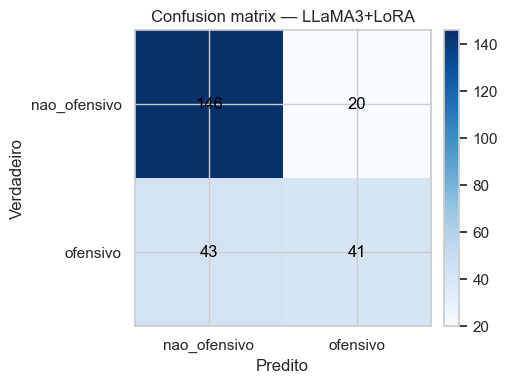

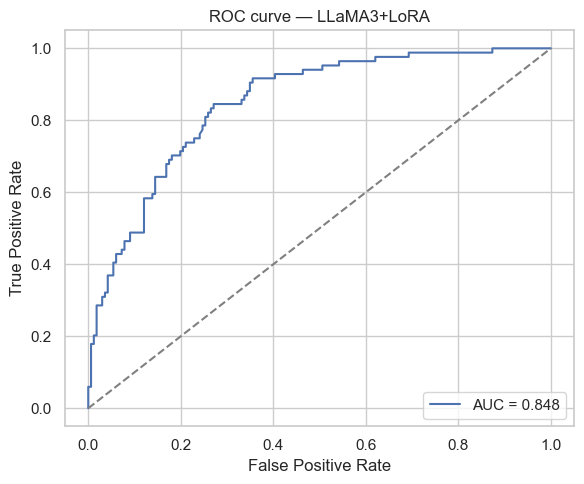

ROC AUC = 0.8481

Finished LLaMA3+LoRA (modelo/tokenizer salvos e objetos em memória).

=== Treinamento / avaliação LLaMA3+LoRA (offcombr-3) ===


Loading checkpoint shards: 100%|██████████| 4/4 [00:34<00:00,  8.54s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128009}.


Starting LLaMA3+LoRA training for offcombr-3.


Epoch,Training Loss,Validation Loss
1,3.962400,0.436118



Classification report (LLaMA3 + LoRA):
              precision    recall  f1-score   support

nao_ofensivo     0.8793    0.9162    0.8974       167
    ofensivo     0.5758    0.4750    0.5205        40

    accuracy                         0.8309       207
   macro avg     0.7275    0.6956    0.7090       207
weighted avg     0.8207    0.8309    0.8245       207

Accuracy = 0.8309 | Precision_macro = 0.7275 | Recall_macro = 0.6956 | F1_macro = 0.7090


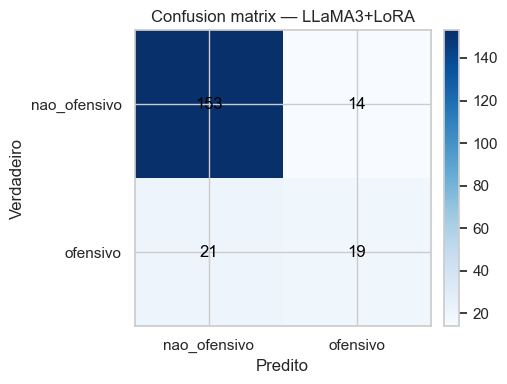

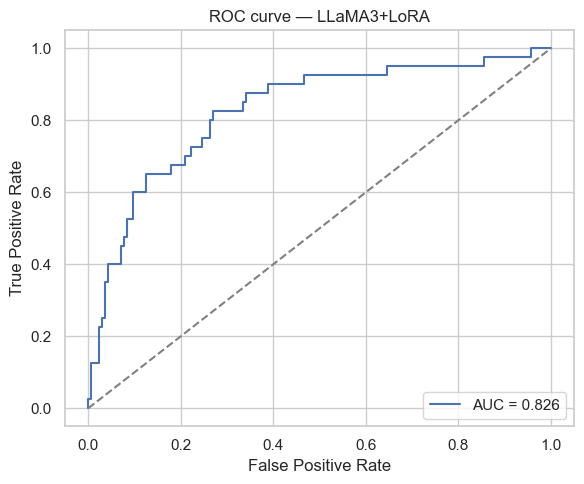

ROC AUC = 0.8262

Finished LLaMA3+LoRA (modelo/tokenizer salvos e objetos em memória).


In [13]:
# =========================
# 6. LLaMA3 + LoRA (treino + salvamento + registro em memória)
# =========================
import gc
from torch.nn.functional import softmax
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)

# ---- dicionários globais para reutilização em 6.1/6.2/7/7.1 ----
if "llama_tok"   not in globals(): llama_tok   = {}
if "llama_model" not in globals(): llama_model = {}
if "llama_metrics" not in globals(): llama_metrics = {}
if "llama_preds"   not in globals(): llama_preds   = {}
if "llama_scores"  not in globals(): llama_scores  = {}
if "llama_ytrue"   not in globals(): llama_ytrue   = {}
if "llama_Xtest"   not in globals(): llama_Xtest   = {}
if "comparacao_datasets" not in globals(): comparacao_datasets = {}

def treinar_llama_lora(
    cfg,
    X_train, y_train,
    X_eval,  y_eval,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    output_dir_base="./results_llama",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    max_len=192,
    use_4bit=True,
    seed=SEED
):
    """
    Fine-tune LLaMA3 para classificação (2 classes) com LoRA (k-bit + LoRA).
    - Mostra classification report, confusion matrix e ROC inline.
    - Salva tokenizer + adapters LoRA.
    - Retorna e registra em memória: tokenizer, model (com LoRA), métricas e predições.
    """
    if 'HAS_PEFT' in globals() and not HAS_PEFT:
        raise RuntimeError("PEFT/bitsandbytes não disponível. Instale 'peft' e 'bitsandbytes' para rodar LLaMA+LoRA.")

    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=True, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    # HF Datasets
    ds_train = Dataset.from_dict({"text": list(X_train), "label": list(map(int, y_train))})
    ds_eval  = Dataset.from_dict({"text": list(X_eval),  "label": list(map(int, y_eval))})

    def tokenize_fn(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_len)

    ds_train = ds_train.map(tokenize_fn, batched=True, remove_columns=["text"])
    ds_eval  = ds_eval.map(tokenize_fn, batched=True, remove_columns=["text"])
    ds_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    ds_eval.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    # Bits & Bytes (k-bit)
    bnb_config = None
    if use_4bit:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )

    # antes de carregar o modelo do próximo cfg:
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Modelo base + head de classificação
    try:
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
        num_labels=2,
        quantization_config=bnb_config,   # 4-bit NF4
        device_map={"": 0},               # <-- força 100% no GPU:0 (evita CPU/disk)
        torch_dtype=torch.float16,        # <-- garante dtype compacto
        attn_implementation="sdpa",       # <-- usa SDPA (mais leve que eager)
        token=True                        # Busca automaticamente o token salvo
        )
    except Exception as e:
        print("[warn] 4-bit com device_map={'':0} falhou:", e)
        raise

    model = prepare_model_for_kbit_training(model)
    try:
        model.gradient_checkpointing_enable()
    except Exception:
        pass

    # LoRA
    lora_config = LoraConfig(
        r=16, lora_alpha=32,
        target_modules=["q_proj", "v_proj", "o_proj", "k_proj"],
        lora_dropout=0.05, bias="none", task_type="SEQ_CLS",
    )
    model = get_peft_model(model, lora_config)

    try:
        model.resize_token_embeddings(len(tokenizer))
    except Exception:
        pass

    outdir = os.path.join(output_dir_base, cfg, "llama_lora")
    os.makedirs(outdir, exist_ok=True)

    args = TrainingArguments(
        output_dir=outdir,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs,
        eval_strategy="epoch",
        save_strategy="epoch",        # <-- salvar ao final de cada época
        logging_strategy="steps",
        logging_steps=50,
        load_best_model_at_end=True,   # baseado em eval_loss
        fp16=torch.cuda.is_available(),
        bf16=False,
        seed=seed,
        save_total_limit=1,
        dataloader_num_workers=2,
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train,
        eval_dataset=ds_eval,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    print(f"Starting LLaMA3+LoRA training for {cfg}.")
    trainer.train()

    # Garantia extra de salvamento (tokenizer + adapters)
    try:
        trainer.save_model(outdir)            # salva adapters LoRA
        tokenizer.save_pretrained(outdir)
    except Exception as e:
        print("[warn] Falha ao salvar modelo/tokenizer:", e)

    # Predições
    pred_out = trainer.predict(ds_eval)
    logits = pred_out.predictions if not isinstance(pred_out.predictions, tuple) else pred_out.predictions[0]

    y_pred = np.argmax(logits, axis=-1)
    y_score = softmax(torch.tensor(logits), dim=-1)[:, 1].cpu().numpy()
    y_true_arr = np.asarray(list(map(int, y_eval)))

    # Relatório
    print("\nClassification report (LLaMA3 + LoRA):")
    print(classification_report(y_true_arr, y_pred, digits=4, target_names=["nao_ofensivo","ofensivo"]))

    # Métricas macro (compatíveis com RF/BERT)
    acc = float(accuracy_score(y_true_arr, y_pred))
    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(y_true_arr, y_pred, average="macro", zero_division=0)
    print(f"Accuracy = {acc:.4f} | Precision_macro = {prec_m:.4f} | Recall_macro = {rec_m:.4f} | F1_macro = {f1_m:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true_arr, y_pred, labels=[0,1])
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, cmap="Blues", interpolation="nearest")
    ax.set_xlabel("Predito"); ax.set_ylabel("Verdadeiro")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["nao_ofensivo","ofensivo"]); ax.set_yticklabels(["nao_ofensivo","ofensivo"])
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, int(val), ha="center", va="center", color="black")
    plt.title("Confusion matrix — LLaMA3+LoRA")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    # ROC AUC (se ambas classes presentes)
    if len(np.unique(y_true_arr)) > 1:
        try:
            auc = float(roc_auc_score(y_true_arr, y_score))
            fpr, tpr, _ = roc_curve(y_true_arr, y_score)
            fig, ax = plt.subplots(figsize=(6,5))
            ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
            ax.plot([0,1],[0,1], linestyle="--", color="grey")
            ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
            ax.set_title("ROC curve — LLaMA3+LoRA")
            ax.legend(loc="lower right")
            plt.tight_layout()
            plt.show()
            print(f"ROC AUC = {auc:.4f}")
        except Exception as e:
            print("Falha ao calcular ROC AUC:", e)
    else:
        print("ROC AUC não calculado: somente uma classe presente.")

    # --- registra em memória (p/ 6.1, 6.2, 7, 7.1) ---
    llama_tok[cfg]   = tokenizer
    llama_model[cfg] = model
    llama_metrics[cfg] = {"accuracy":acc, "precision_macro":float(prec_m),
                          "recall_macro":float(rec_m), "f1_macro":float(f1_m)}
    llama_preds[cfg]  = y_pred
    llama_scores[cfg] = y_score
    llama_ytrue[cfg]  = y_true_arr
    llama_Xtest[cfg]  = list(X_eval)

    # Atualiza sua estrutura comparacao_datasets (mantendo compatibilidade)
    prev_results = comparacao_datasets.get(cfg + "_raw_results", [])
    res_llama = {
        "Modelo": "LLaMA3 + LoRA",
        "cfg": cfg,
        "Accuracy": acc,
        "Precision": float(prec_m),
        "Recall": float(rec_m),
        "F1-score": float(f1_m),
        "y_score": y_score,
        "y_pred": y_pred
    }
    comparacao_datasets[cfg + "_raw_results"] = prev_results + [res_llama]
    comparacao_datasets[cfg + "_ytest"] = y_true_arr
    comparacao_datasets[cfg + "_Xtest"] = list(X_eval)
    comparacao_datasets[cfg] = pd.DataFrame([{
        "Modelo":"LLaMA3 + LoRA", "cfg": cfg, "Accuracy": acc,
        "Precision": float(prec_m), "Recall": float(rec_m), "F1-score": float(f1_m)
    }])

    print("\nFinished LLaMA3+LoRA (modelo/tokenizer salvos e objetos em memória).")
    return {"tokenizer": tokenizer, "model": model, "metrics": llama_metrics[cfg],
            "y_pred": y_pred, "y_score": y_score, "y_true": y_true_arr, "outdir": outdir}

# --------------------------
# Execução por CONFIG (inline results)
# --------------------------
for cfg in CONFIGS:
    print(f"\n=== Treinamento / avaliação LLaMA3+LoRA ({cfg}) ===")
    # LLaMA3 usa texto bruto (raw) como BERTimbau
    X_train = splits[cfg]["train_text_raw"] if "train_text_raw" in splits[cfg] else splits[cfg]["train_text"]
    y_train = splits[cfg]["train_y"]
    X_test  = splits[cfg]["test_text_raw"] if "test_text_raw" in splits[cfg] else splits[cfg]["test_text"]
    y_test  = splits[cfg]["test_y"]
    _ = treinar_llama_lora(
        cfg,
        X_train, y_train,
        X_test,  y_test,
        model_name="meta-llama/Meta-Llama-3-8B-Instruct",
        output_dir_base="./results_llama",
        num_train_epochs=1,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=8,
        learning_rate=2e-4,
        max_len=256,
        use_4bit=True
    )

## 6.1. Avaliador LLM (Llama3 Instruct) + 6.2 SHAP no LLM (masker de texto) ##


=== SHAP: LLaMA3+LoRA (offcombr-2) ===
Usando 250 textos de teste de splits[offcombr-2]['test_text'].
Rodando SHAP em 100 textos…


 99%|█████████▉| 494/498 [00:24<00:00, 16.72it/s]
500it [00:24, 16.85it/s]                         
504it [00:25, 14.77it/s]
 99%|█████████▉| 494/498 [00:26<00:00, 15.99it/s]
500it [00:26, 15.72it/s]                         
504it [00:26, 14.12it/s]
 99%|█████████▉| 494/498 [00:26<00:00, 15.63it/s]
500it [00:26, 15.27it/s]                         
504it [00:27, 14.02it/s]
 99%|█████████▉| 494/498 [00:26<00:00, 15.15it/s]
500it [00:27, 15.58it/s]                         
504it [00:27, 13.64it/s]
 99%|█████████▉| 494/498 [00:26<00:00, 14.62it/s]
500it [00:27, 15.16it/s]                         
504it [00:27, 13.92it/s]
 99%|█████████▉| 494/498 [00:26<00:00, 14.18it/s]
500it [00:27, 13.75it/s]                         
504it [00:27, 12.46it/s]
 99%|█████████▉| 494/498 [00:26<00:00, 15.81it/s]
500it [00:26, 15.69it/s]                         
504it [00:26, 14.01it/s]
100%|██████████| 182/182 [00:06<00:00, 17.16it/s]
188it [00:06, 16.32it/s]                         
192it [00:07, 14.29it/s]


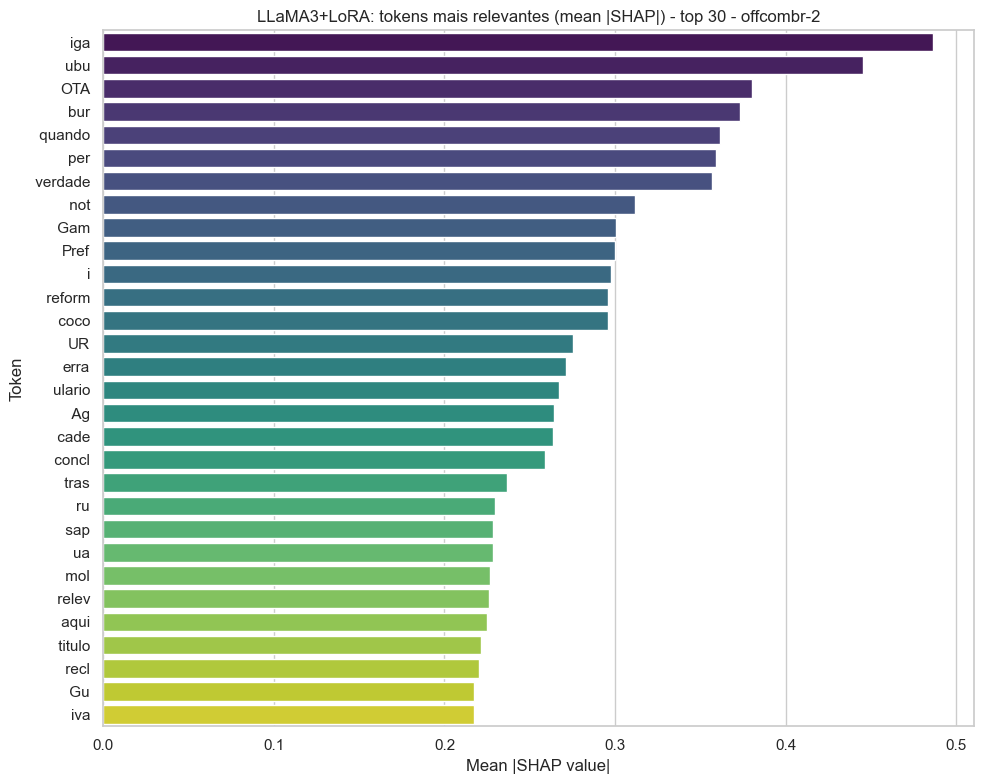

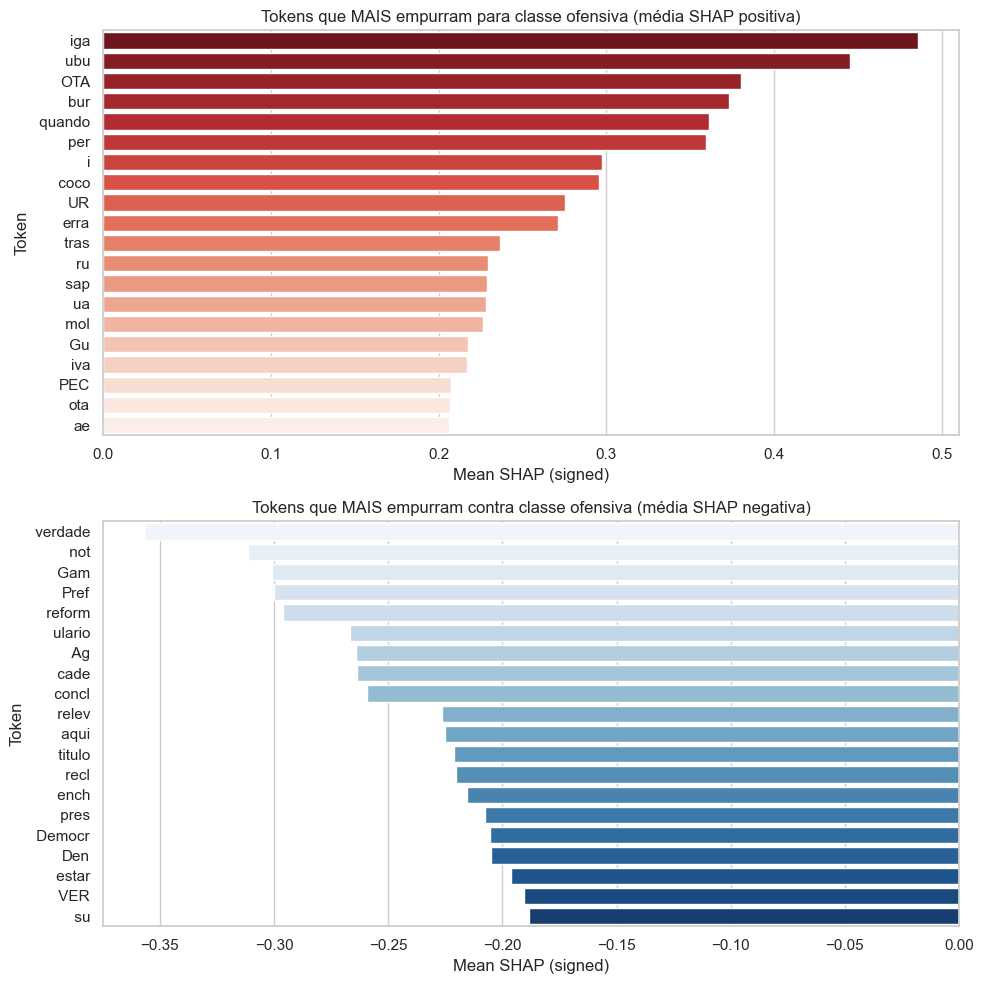

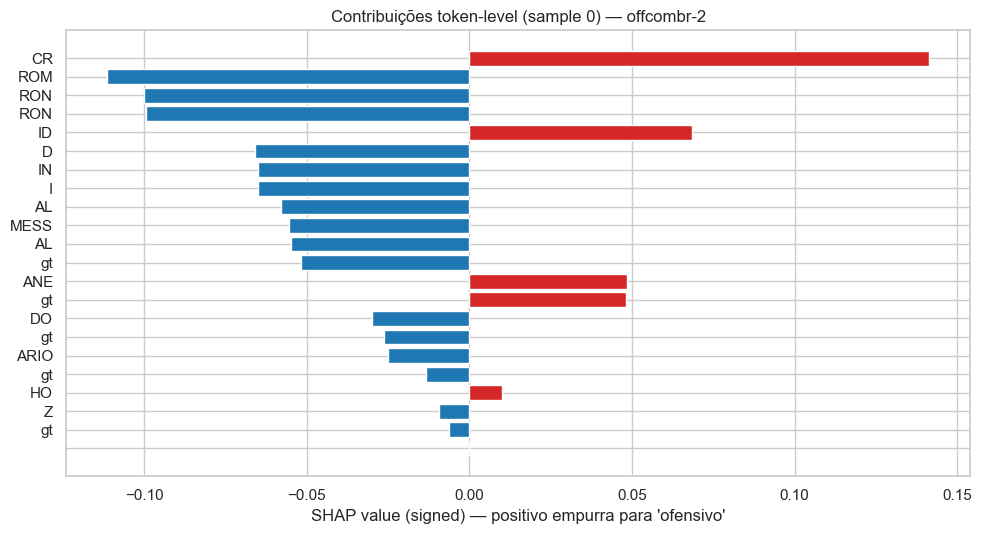

Sample 0 text (preprocessed): ROMARIOgtRONALDOgtZIDANEgtMESSIgtRONALDINHOgtCR


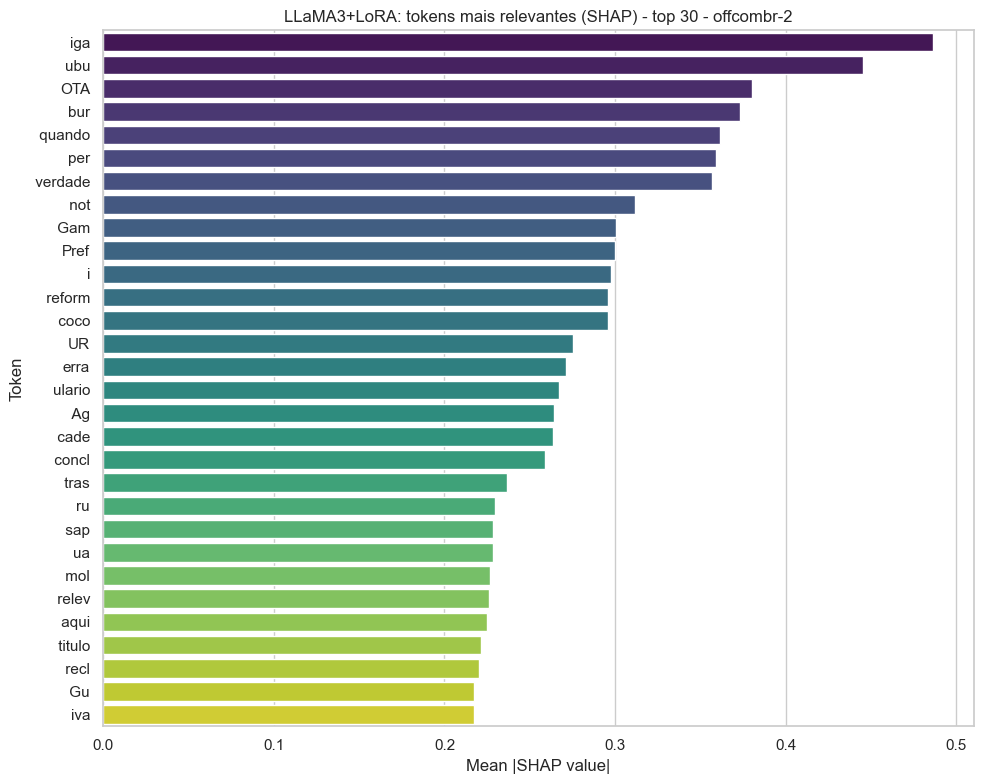


=== SHAP: LLaMA3+LoRA (offcombr-3) ===
Usando 207 textos de teste de splits[offcombr-3]['test_text'].
Rodando SHAP em 90 textos…


 99%|█████████▉| 494/498 [00:26<00:00, 15.09it/s]
500it [00:26, 15.84it/s]                         
504it [00:26, 14.61it/s]
 99%|█████████▉| 494/498 [00:26<00:00, 13.65it/s]
500it [00:27, 12.98it/s]                         
504it [00:27, 12.35it/s]
 99%|█████████▉| 494/498 [00:24<00:00, 16.62it/s]
500it [00:24, 16.27it/s]                         
504it [00:24, 14.73it/s]
 99%|█████████▉| 494/498 [00:25<00:00, 15.90it/s]
500it [00:25, 15.41it/s]                         
504it [00:26, 14.43it/s]
 99%|█████████▉| 494/498 [00:24<00:00, 16.57it/s]
500it [00:25, 16.62it/s]                         
504it [00:25, 15.21it/s]
 99%|█████████▉| 494/498 [00:24<00:00, 16.96it/s]
500it [00:25, 16.34it/s]                         
504it [00:25, 14.71it/s]
 99%|█████████▉| 494/498 [00:25<00:00, 16.45it/s]
500it [00:25, 16.79it/s]                         
504it [00:25, 15.07it/s]
 99%|█████████▉| 494/498 [00:25<00:00, 15.87it/s]
500it [00:25, 15.78it/s]                         
504it [00:26, 14.12it/s]


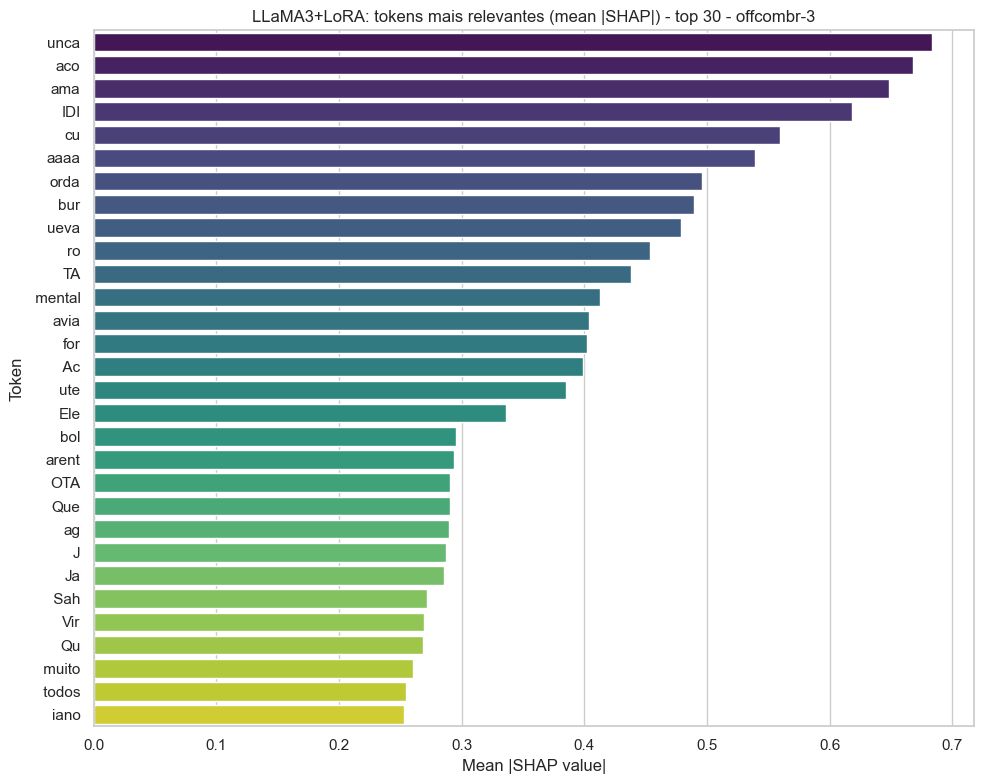

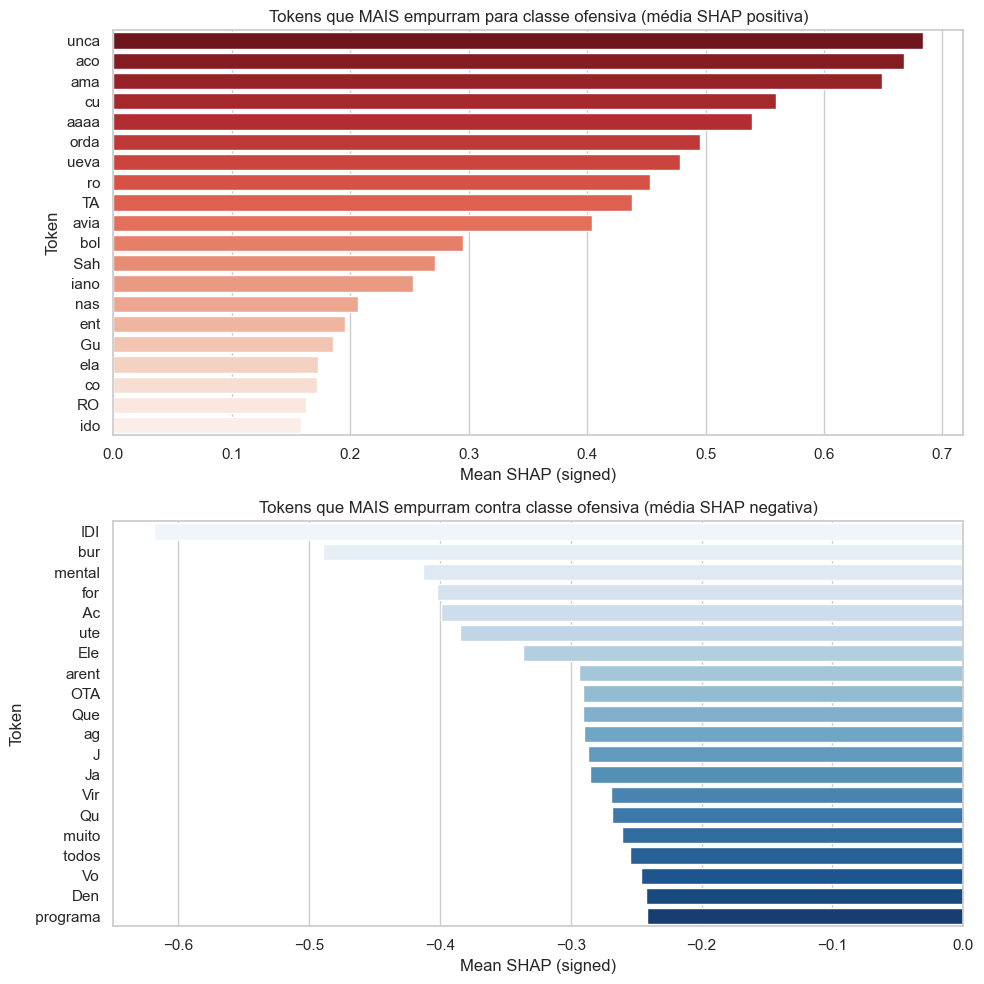

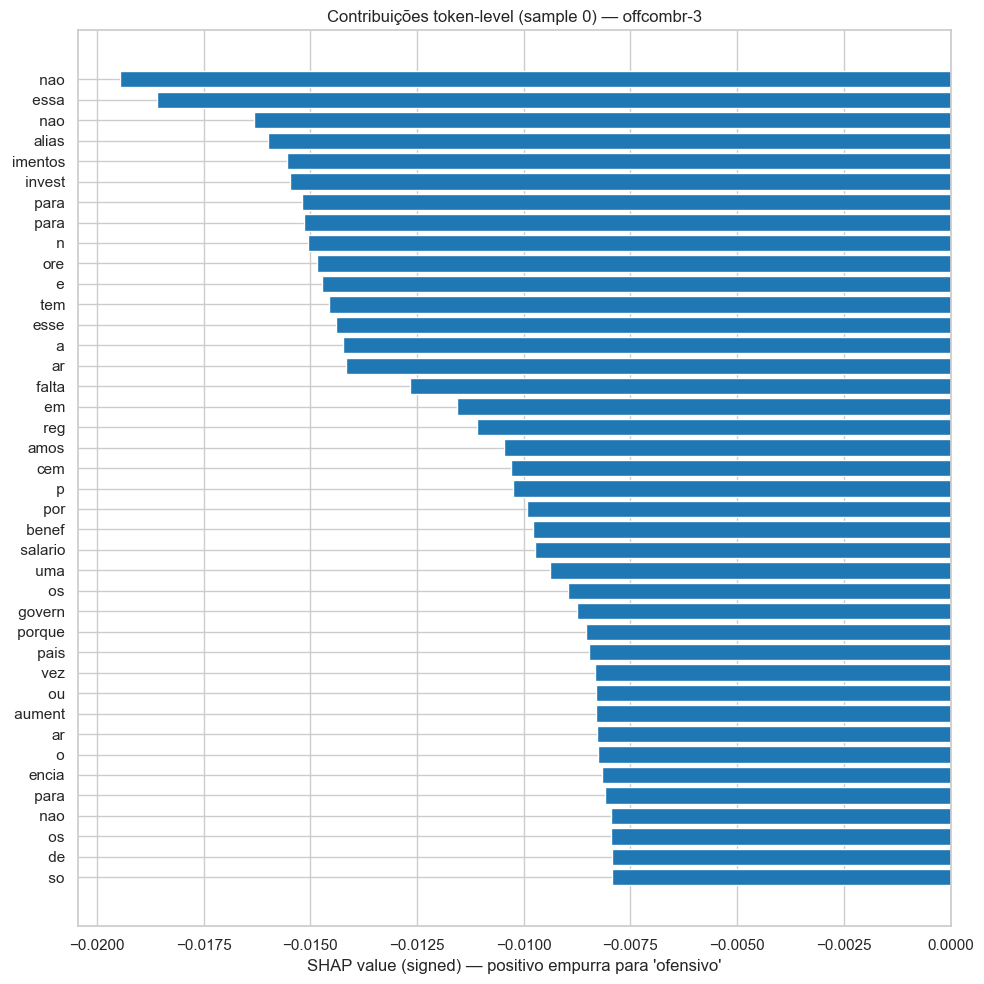

Sample 0 text (preprocessed): Sabe o que eu acho engracado os nossos governantes  nao pensam em cortar regalias e beneficios desnecessarios que os favorecem porque sera ne e mais do que claro ate mesmo para quem nao quer enxergar eles sao estao la para defender seus proprios interesses  e os dos empresario o no casso eles tambem ou comecamos a tomar uma atitude para mudar de uma vez por todas essa roubalheira nesse pais o a tendencia e so piorar para o povo porque dinheiro para investimentos nao tem mais para aumentos de salario e regalias nao falta


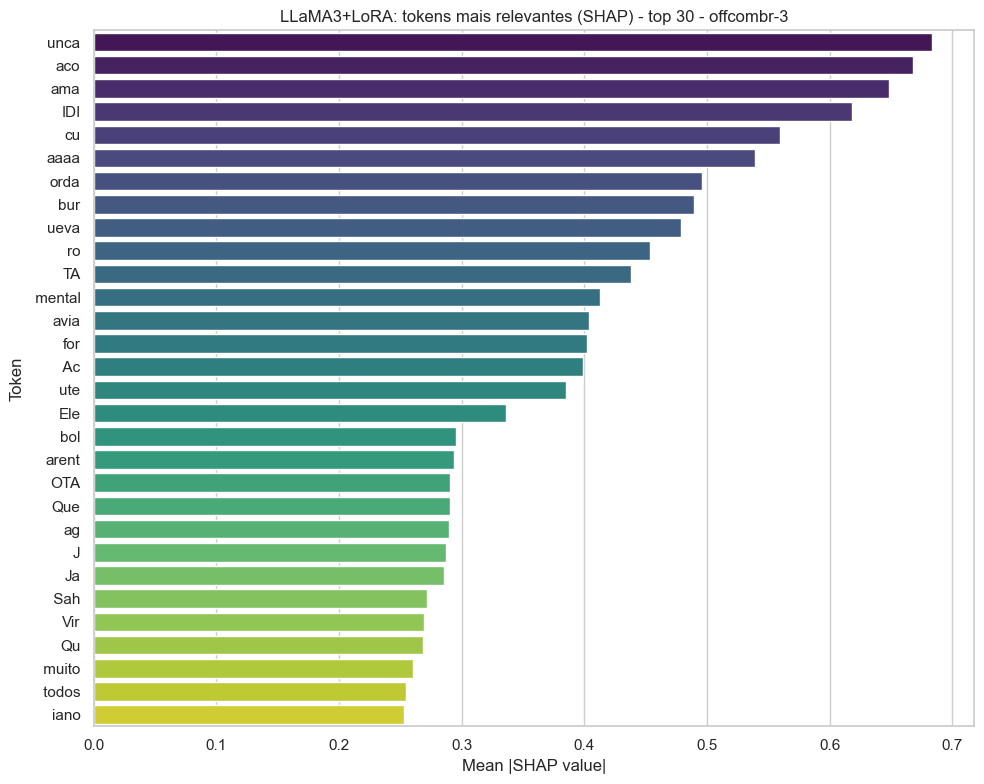

In [14]:
# ============================================================
# 6.1 Avaliador LLaMA3+LoRA + 6.2 SHAP para LLaMA3+LoRA (masker de texto)
# ============================================================
sns.set(style="whitegrid", font_scale=1.0)
device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("./outputs/shap", exist_ok=True)

def make_predict_proba_fn_llama(tokenizer, model, device):
    """Retorna função predict_proba(texts)-> array (N,) com prob. da classe ofensiva (índice 1)."""
    model.to(device)
    model.eval()
    def predict_proba(texts, batch_size=16, max_length=256):
        probs = []
        with torch.no_grad():
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tokenizer(list(batch), padding=True, truncation=True, max_length=max_length, return_tensors="pt")
                enc = {k: v.to(device) for k, v in enc.items()}
                logits = model(**enc).logits
                p = torch.softmax(logits, dim=-1)[:, 1].detach().cpu().numpy()  # classe positiva = ofensivo
                probs.append(p)
        if len(probs) == 0:
            return np.array([])
        return np.concatenate(probs, axis=0)
    return predict_proba

for cfg in CONFIGS:
    try:
        print(f"\n=== SHAP: LLaMA3+LoRA ({cfg}) ===")

        # Verifica existência do modelo/tokenizer treinados na Seção 6
        if cfg not in llama_tok or cfg not in llama_model:
            print(f"[LLAMA:{cfg}] Modelo/tokenizer não encontrados. Execute a Seção 6 antes.")
            continue

        test_texts = list(splits[cfg]["test_text_raw"]) if "test_text_raw" in splits[cfg] else list(splits[cfg]["test_text"]) 
        if len(test_texts) == 0:
            print(f"Não há textos de teste em splits[{cfg}]['test_text']. Pulando.")
            continue
        print(f"Usando {len(test_texts)} textos de teste de splits[{cfg}]['test_text'].")
        y_true = np.asarray(splits[cfg]["test_y"]) 

        tokenizer_llama = llama_tok[cfg]
        model_llama = llama_model[cfg]

        # --- 6.1 Avaliador — métricas de sanity inline ---
        # Calcula preds rapidamente para relatório
        with torch.no_grad():
            # usa a mesma função de prob. que alimenta o SHAP
            predict_proba = make_predict_proba_fn_llama(tokenizer_llama, model_llama, device)
            p_off = predict_proba(test_texts, batch_size=16, max_length=256)
            y_pred = (p_off >= 0.5).astype(int)
        y_true = np.asarray(splits[cfg]["test_y"])

        # --- 6.2 SHAP textual ---
        masker = shap.maskers.Text(tokenizer_llama)
        explainer = shap.Explainer(predict_proba, masker)

        # Subconjunto estratificado até 100 (≈50 pos, 50 neg quando possível)
        pos_idx = np.where(y_true == 1)[0].tolist()
        neg_idx = np.where(y_true == 0)[0].tolist()
        k = 50
        sel_idx = (neg_idx[:k] + pos_idx[:k]) if (pos_idx and neg_idx) else list(range(min(100, len(test_texts))))
        subset = [test_texts[i] for i in sel_idx]
        print(f"Rodando SHAP em {len(subset)} textos…")
        shap_explanations = explainer(subset)

        # ---- Agregação: mean |SHAP| por token e média assinada (direção) ----
        tokens_abs = []
        tokens_signed = []
        for ex in shap_explanations:
            toks = ex.data
            vals = ex.values
            # Normaliza shape: (n_tokens,) esperado; se vier (1, n_tokens), pega o primeiro
            if hasattr(vals, "ndim") and vals.ndim == 2:
                vals = vals[0]
            # tokens especiais do tokenizer (p.ex. <s>, </s>, <pad>) não entram no ranking
            for t, v in zip(toks, vals):
                if t in tokenizer_llama.all_special_tokens:
                    continue
                v = float(v)
                tokens_abs.append({"token": t, "abs_shap": abs(v)})
                tokens_signed.append({"token": t, "signed_shap": v})

        df_abs = pd.DataFrame(tokens_abs)
        df_signed = pd.DataFrame(tokens_signed)
        if df_abs.empty or df_signed.empty:
            raise RuntimeError("Nenhum token válido encontrado para agregação SHAP (LLaMA).")

        df_token_summary = df_abs.groupby("token")["abs_shap"].mean().reset_index()
        df_token_summary = df_token_summary.sort_values("abs_shap", ascending=False)

        df_token_signed = df_signed.groupby("token")["signed_shap"].mean().reset_index()
        df_token_signed = df_token_signed.sort_values("signed_shap", ascending=False)

        # ---- Plot 1: Importância global (mean |SHAP|) ----
        plt.figure(figsize=(10, 8))
        topn = 30
        sns.barplot(data=df_token_summary.head(topn), x="abs_shap", y="token", palette="viridis")
        plt.xlabel("Mean |SHAP value|")
        plt.ylabel("Token")
        plt.title(f"LLaMA3+LoRA: tokens mais relevantes (mean |SHAP|) - top {topn} - {cfg}")
        plt.tight_layout()
        plt.show()

        # ---- Plot 2: Importância assinada (direção p/ classe ofensiva) ----
        top_pos = df_token_signed.sort_values("signed_shap", ascending=False).head(20)
        top_neg = df_token_signed.sort_values("signed_shap", ascending=True).head(20)

        plt.figure(figsize=(10, 10))
        plt.subplot(2,1,1)
        sns.barplot(data=top_pos, x="signed_shap", y="token", palette="Reds_r")
        plt.title("Tokens que MAIS empurram para classe ofensiva (média SHAP positiva)")
        plt.xlabel("Mean SHAP (signed)"); plt.ylabel("Token")

        plt.subplot(2,1,2)
        sns.barplot(data=top_neg, x="signed_shap", y="token", palette="Blues")
        plt.title("Tokens que MAIS empurram contra classe ofensiva (média SHAP negativa)")
        plt.xlabel("Mean SHAP (signed)"); plt.ylabel("Token")

        plt.tight_layout()
        plt.show()

        # ---- Plot 3: Explicação local (amostra 0 do subset) ----
        if len(shap_explanations) > 0:
            ex0 = shap_explanations[0]
            toks0 = ex0.data
            vals0 = ex0.values
            if hasattr(vals0, "ndim") and vals0.ndim == 2:
                vals0 = vals0[0]

            token_vals = [(t, float(v)) for t, v in zip(toks0, vals0) if t not in tokenizer_llama.all_special_tokens]
            if token_vals:
                names = [t for t, _ in token_vals]
                vals = np.array([v for _, v in token_vals], dtype=float)
                order = np.argsort(np.abs(vals))[::-1][:40]
                vals_plot = vals[order]
                names_plot = np.array(names)[order]

                plt.figure(figsize=(10, max(3, len(names_plot)*0.25)))
                colors = ["tab:red" if v > 0 else "tab:blue" for v in vals_plot]
                plt.barh(range(len(vals_plot)), vals_plot, color=colors)
                plt.yticks(range(len(vals_plot)), names_plot)
                plt.gca().invert_yaxis()
                plt.xlabel("SHAP value (signed) — positivo empurra para 'ofensivo'")
                plt.title(f"Contribuições token-level (sample 0) — {cfg}")
                plt.tight_layout()
                plt.show()

                print("Sample 0 text (preprocessed):", subset[0])

        # um segundo gráfico global repetindo top tokens
        plt.figure(figsize=(10, 8))
        topn = 30
        sns.barplot(data=df_token_summary.head(topn), x="abs_shap", y="token", palette="viridis")
        plt.xlabel("Mean |SHAP value|")
        plt.ylabel("Token")
        plt.title(f"LLaMA3+LoRA: tokens mais relevantes (SHAP) - top {topn} - {cfg}")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"SHAP LLaMA3+LoRA falhou para {cfg}:", e)

## 7. Comparação Final (Random Forest vs. BERTimbau vs. LLM Llama3) + 7.1 Interpretação de Erros (Random Forest × BERTimbau x LLM Llama3) ##
Esta seção mostra amostras mal classificadas com suas explicações SHAP.
- RF: gráfico de barras com contribuições locais (TF‑IDF).
- BERTimbau: explicação textual com `shap.maskers.Text`.
- LLM Llama3: explicação textual com `shap.maskers.Text`.


In [15]:
# 4.2 — Baseline forte: TF-IDF (word uni/bi + char 3–5) + Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

lr_pipes = {}
lr_metrics = {}

for cfg in CONFIGS:
    print(f"\n=== Logistic Regression @ {cfg} (char+word TF-IDF) ===")
    tr_texts = list(splits[cfg]["train_text"])  # usa texto pré-processado (n-grams de palavras)
    te_texts = list(splits[cfg]["test_text"])   
    tr_y     = np.asarray(splits[cfg]["train_y"]) 
    te_y     = np.asarray(splits[cfg]["test_y"])  

    # Vetorizador híbrido: palavra (1–2) + caractere (3–5)
    # Fazemos dois vetores e concatenamos via FeatureUnion-like simples por Pipeline separado
    word_vec = TfidfVectorizer(max_features=MAX_FEATURES_TFIDF, ngram_range=(1,2), analyzer="word")
    char_vec = TfidfVectorizer(max_features=MAX_FEATURES_TFIDF, ngram_range=(3,5), analyzer="char")

    # Ajusta e concatena manualmente (para simplicidade e transparência)
    Xw_tr = word_vec.fit_transform(tr_texts)
    Xc_tr = char_vec.fit_transform(tr_texts)
    from scipy.sparse import hstack
    X_tr = hstack([Xw_tr, Xc_tr])

    Xw_te = word_vec.transform(te_texts)
    Xc_te = char_vec.transform(te_texts)
    X_te = hstack([Xw_te, Xc_te])

    clf = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
    clf.fit(X_tr, tr_y)

    proba = clf.predict_proba(X_te)[:,1]
    y_pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(te_y, y_pred)
    p_m, r_m, f1_m, _ = precision_recall_fscore_support(te_y, y_pred, average="macro", zero_division=0)
    ap = average_precision_score(te_y, proba)

    print(f"Accuracy={acc:.4f} | Precision_macro={p_m:.4f} | Recall_macro={r_m:.4f} | F1_macro={f1_m:.4f} | AP={ap:.4f}")

    # Armazena componentes para uso na seção 7
    lr_pipes[cfg] = {"word_vec": word_vec, "char_vec": char_vec, "clf": clf}
    lr_metrics[cfg] = {"accuracy":acc, "precision_macro":p_m, "recall_macro":r_m, "f1_macro":f1_m, "AP":ap}


=== Logistic Regression @ offcombr-2 (char+word TF-IDF) ===
Accuracy=0.8040 | Precision_macro=0.7904 | Recall_macro=0.7554 | F1_macro=0.7675 | AP=0.8218

=== Logistic Regression @ offcombr-3 (char+word TF-IDF) ===
Accuracy=0.8696 | Precision_macro=0.8572 | Recall_macro=0.6910 | F1_macro=0.7332 | AP=0.6927



=== Comparação de Modelos - OFFCOMBR-2 ===


,Modelo,cfg,accuracy,precision_macro,recall_macro,f1_macro,precision_pos,recall_pos,f1_pos
0,RandomForest,offcombr-2,0.804,0.805063,0.740677,0.757996,0.807018,0.547619,0.652482
1,LogReg (char+word TF-IDF),offcombr-2,0.804,0.790433,0.755379,0.767548,0.761194,0.607143,0.675497
2,BERTimbau,offcombr-2,0.844,0.823609,0.832544,0.827650,0.752809,0.797619,0.774566
3,LLaMA3+LoRA,offcombr-2,0.752,0.727008,0.689759,0.700101,0.677419,0.500000,0.575342


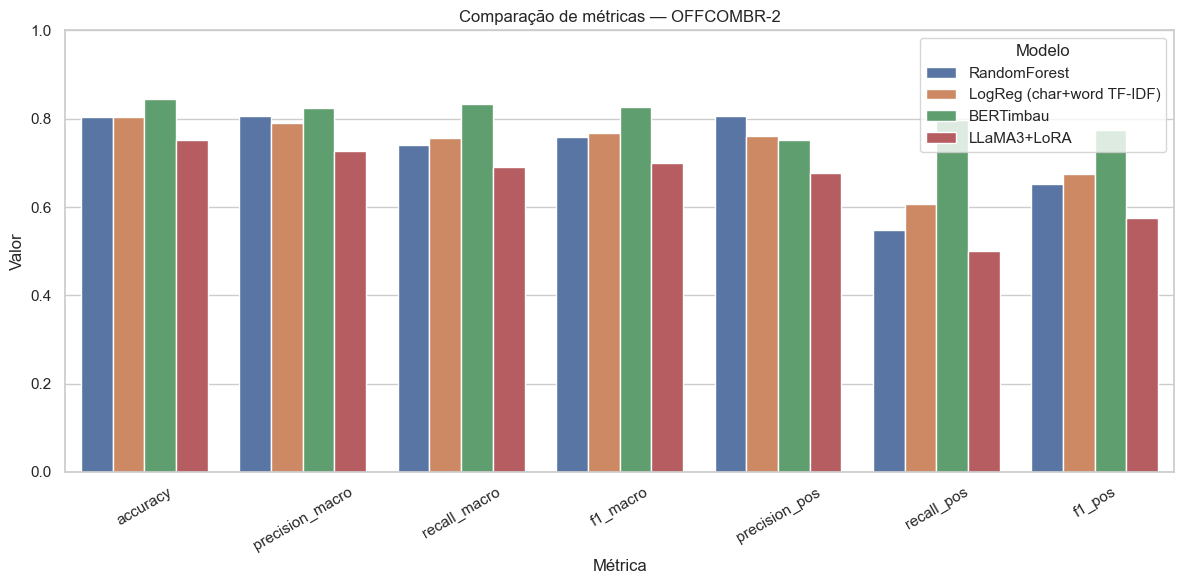

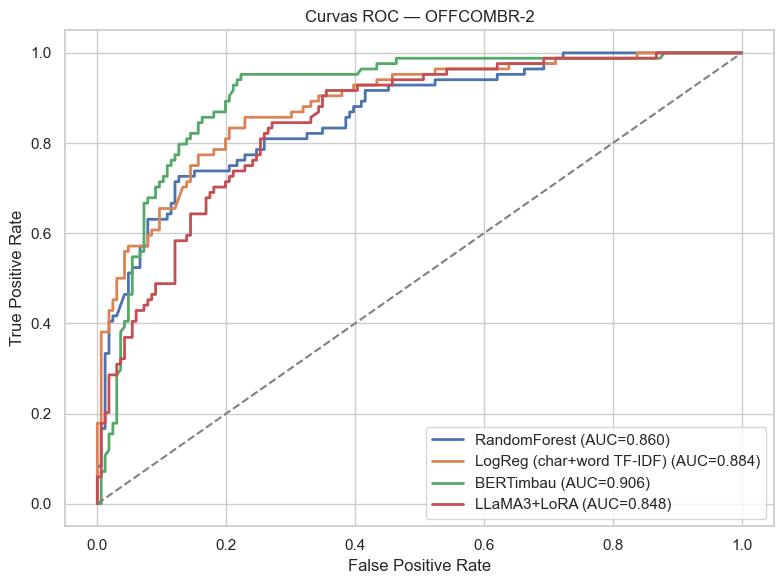

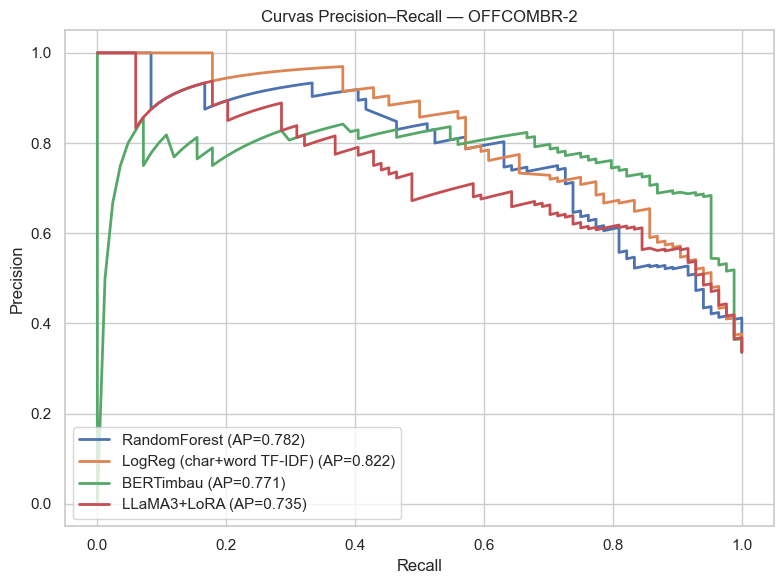

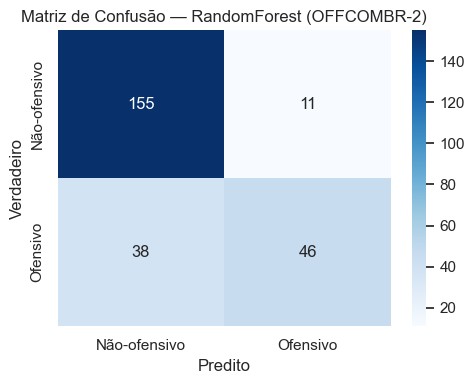

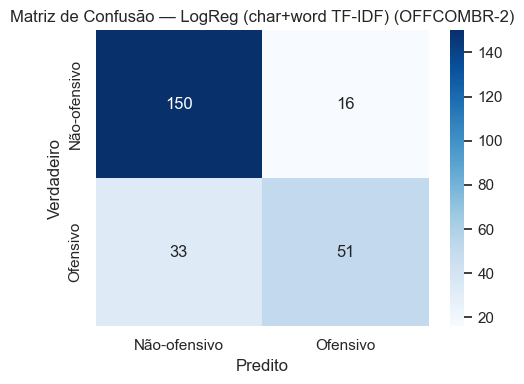

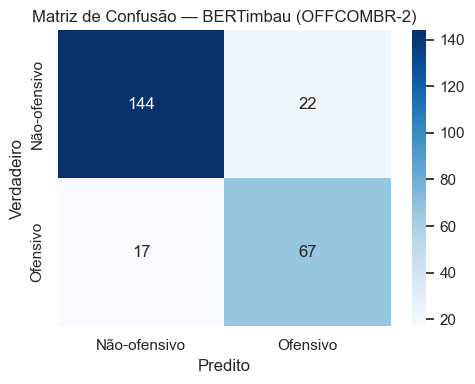

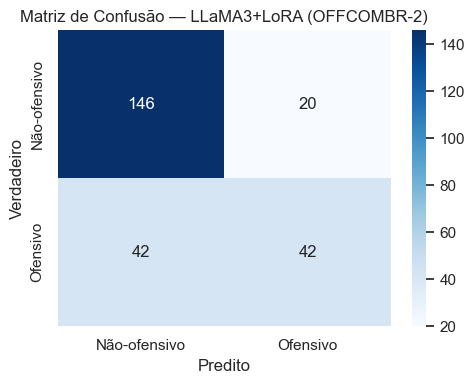

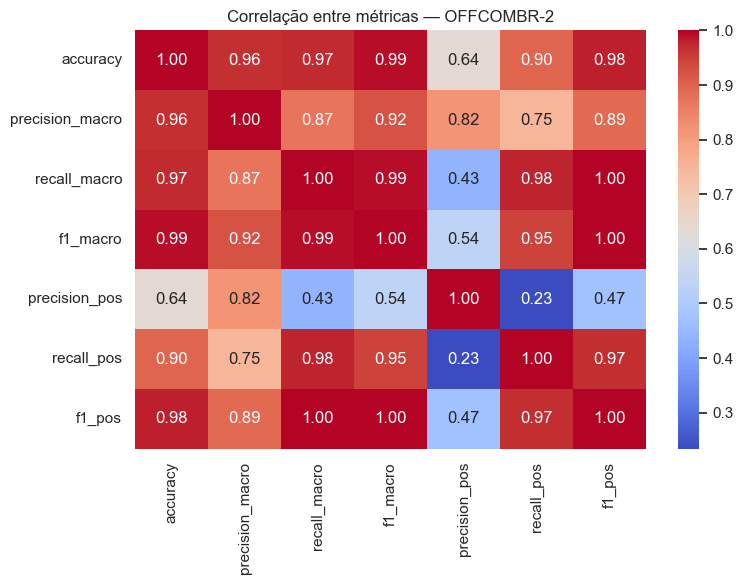


=== Comparação de Modelos - OFFCOMBR-3 ===


,Modelo,cfg,accuracy,precision_macro,recall_macro,f1_macro,precision_pos,recall_pos,f1_pos
0,RandomForest,offcombr-3,0.830918,0.843571,0.572006,0.579976,0.857143,0.150,0.255319
1,LogReg (char+word TF-IDF),offcombr-3,0.869565,0.857223,0.691018,0.733158,0.842105,0.400,0.542373
2,BERTimbau,offcombr-3,0.864734,0.807374,0.716542,0.747649,0.730769,0.475,0.575758
3,LLaMA3+LoRA,offcombr-3,0.830918,0.727534,0.695584,0.708954,0.575758,0.475,0.520548


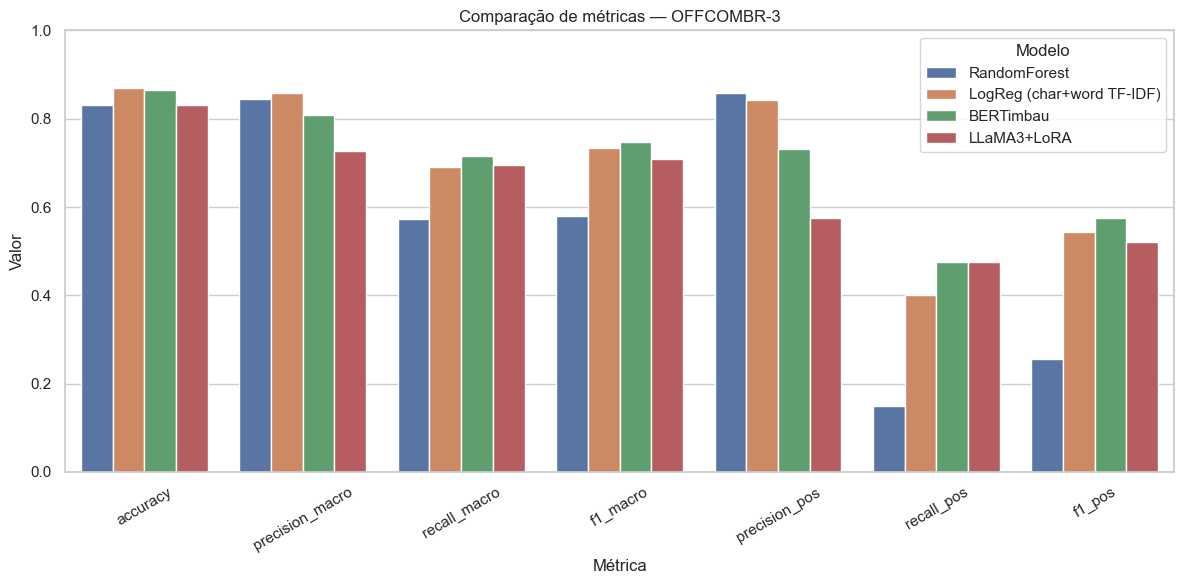

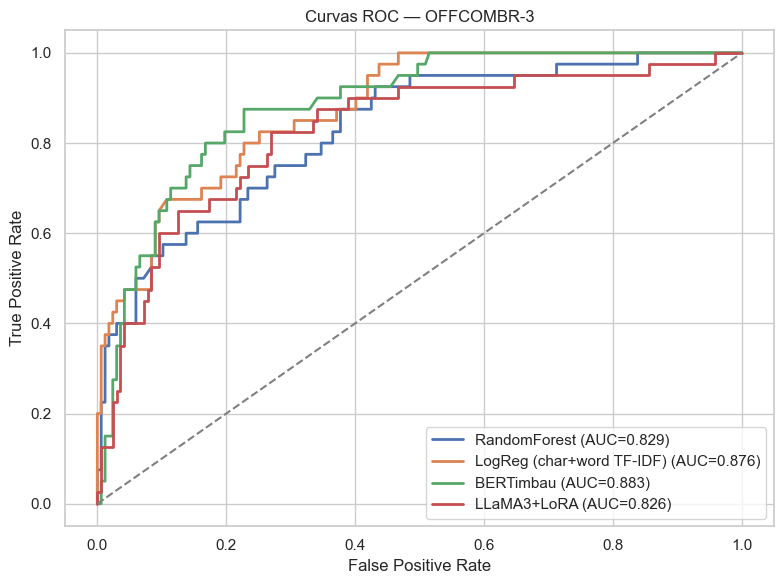

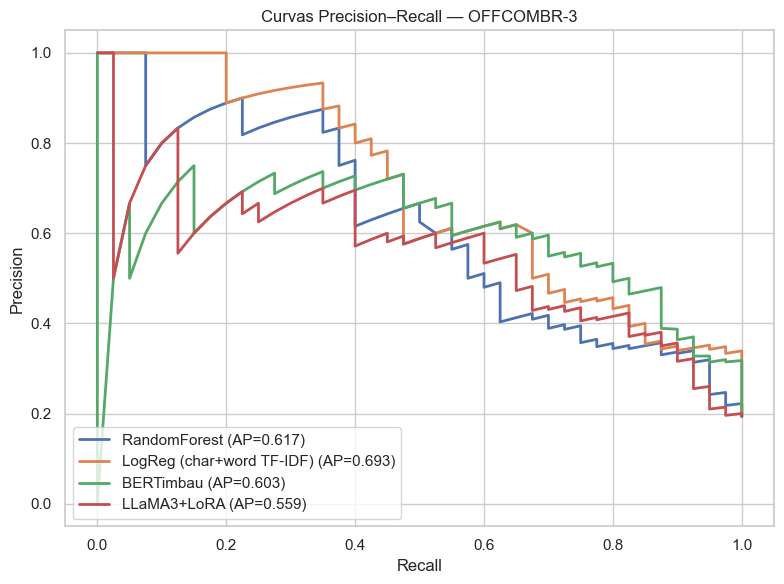

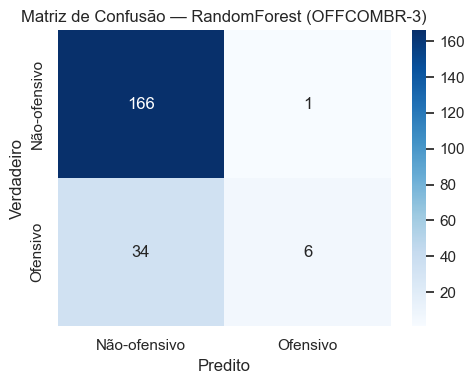

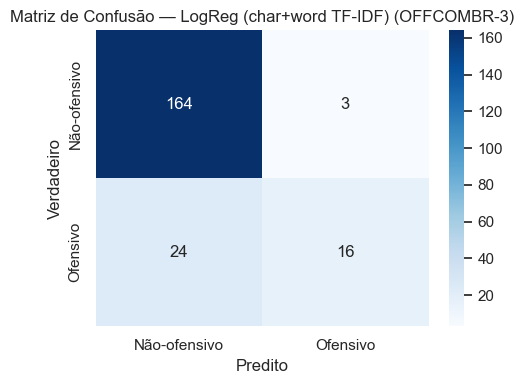

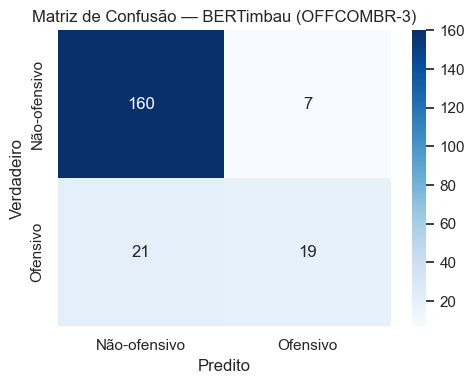

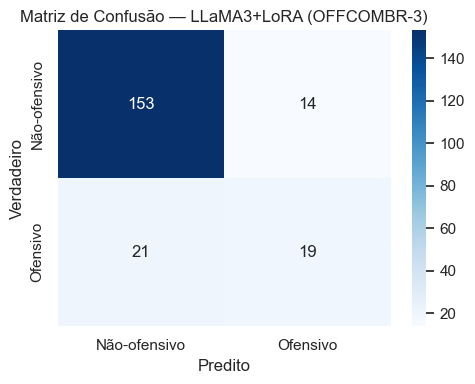

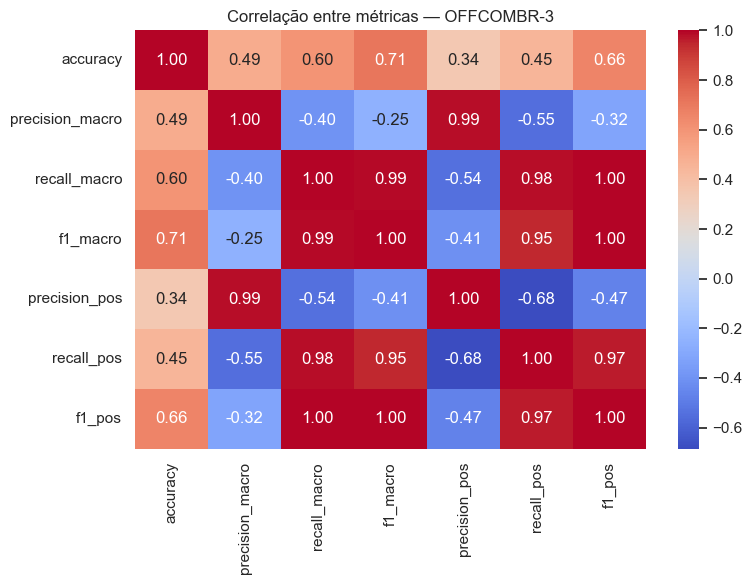


=== Tabela consolidada (por dataset) ===


cfg  accuracy  precision_macro  \
           Modelo                                                             
offcombr-2 RandomForest               offcombr-2  0.804000         0.805063   
           LogReg (char+word TF-IDF)  offcombr-2  0.804000         0.790433   
           BERTimbau                  offcombr-2  0.844000         0.823609   
           LLaMA3+LoRA                offcombr-2  0.752000         0.727008   
offcombr-3 RandomForest               offcombr-3  0.830918         0.843571   
           LogReg (char+word TF-IDF)  offcombr-3  0.869565         0.857223   
           BERTimbau                  offcombr-3  0.864734         0.807374   
           LLaMA3+LoRA                offcombr-3  0.830918         0.727534   

                                      recall_macro  f1_macro  precision_pos  \
           Modelo                                                             
offcombr-2 RandomForest                   0.740677  0.757996       0.807018   
           LogReg (char+word TF-IDF)      0.755379  0.767548       0.761194   
           BERTimbau                      0.832544  0.827650       0.752809   
           LLaMA3+LoRA                    0.689759  0.700101       0.677419   
offcombr-3 RandomForest                   0.572006  0.579976       0.857143   
           LogReg (char+word TF-IDF)      0.691018  0.733158       0.842105   
           BERTimbau                      0.716542  0.747649       0.730769   
           LLaMA3+LoRA                    0.695584  0.708954       0.575758   

                                      recall_pos    f1_pos  
           Modelo                                           
offcombr-2 RandomForest                 0.547619  0.652482  
           LogReg (char+word TF-IDF)    0.607143  0.675497  
           BERTimbau                    0.797619  0.774566  
           LLaMA3+LoRA                  0.500000  0.575342  
offcombr-3 RandomForest                 0.150000  0.255319  
           LogReg (char+word TF-IDF)    0.400000  0.542373  
           BERTimbau                    0.475000  0.575758  
           LLaMA3+LoRA                  0.475000  0.520548

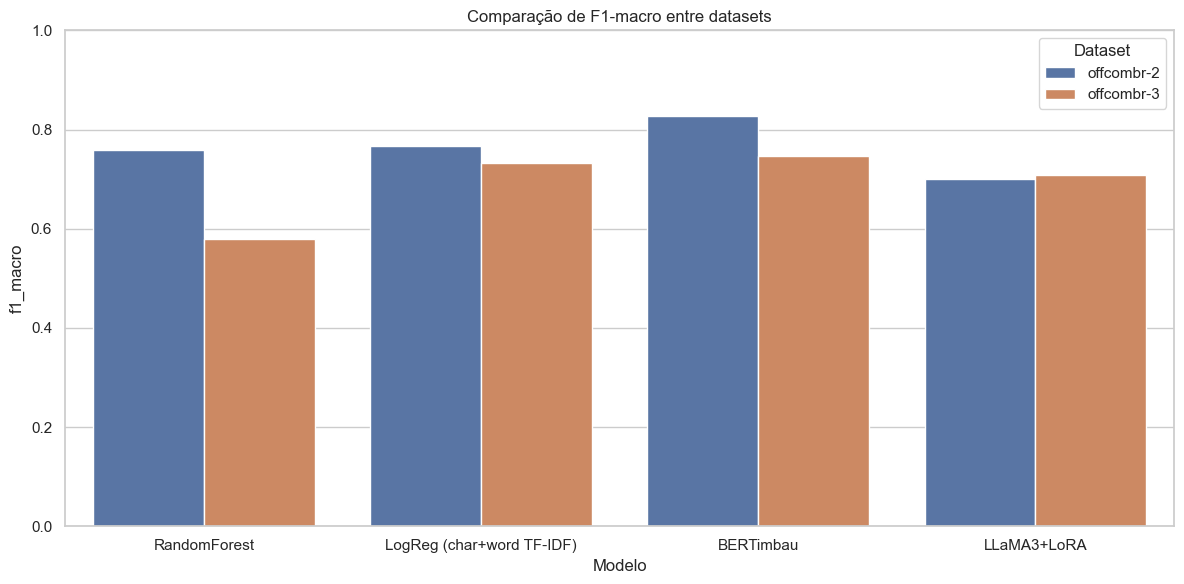

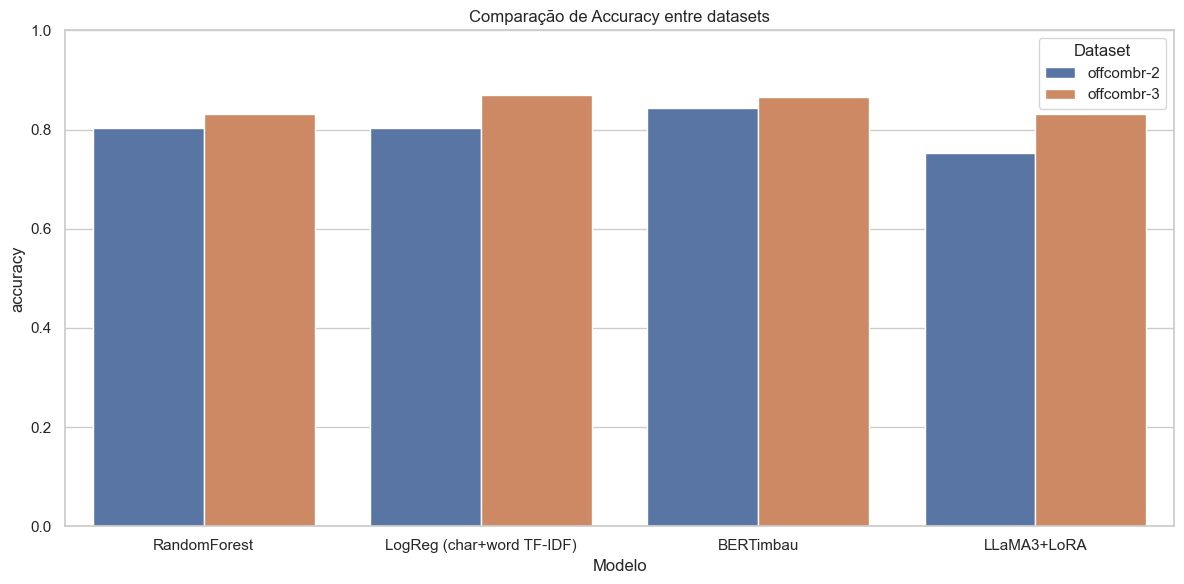


### Interpretação de erros — offcombr-2

------------------------------------------------------------------------------------------
[idx=1] TRUE=1 | Texto: flam aproveita juiz bandeirinhas profissional
  - RF: PRED=0 | score=0.376
  - BERT: PRED=1 | score=0.873
  - LLAMA: PRED=0 | score=0.005


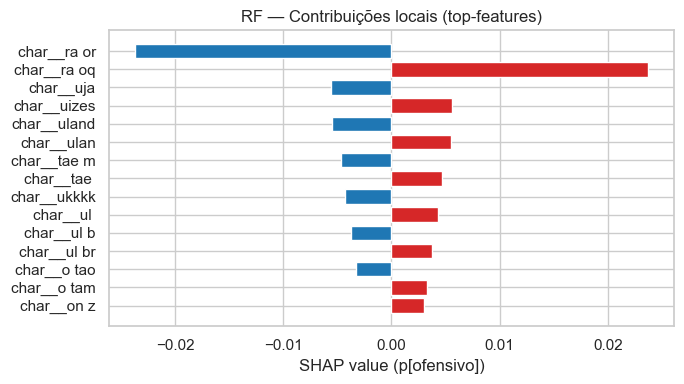

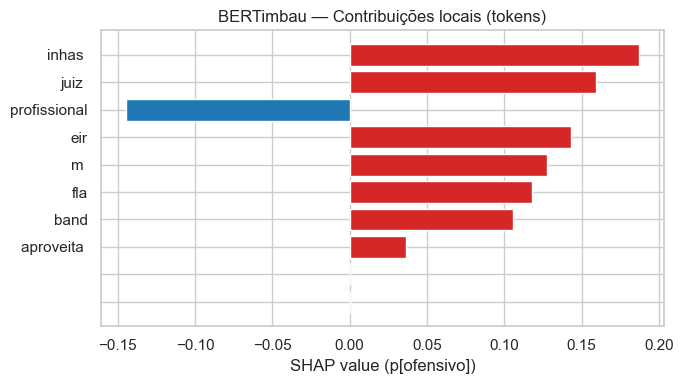

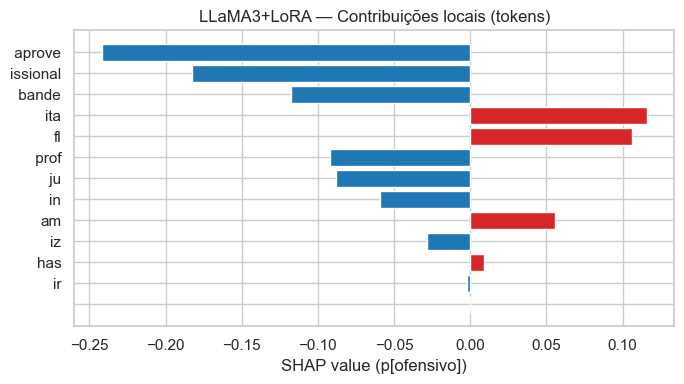


------------------------------------------------------------------------------------------
[idx=2] TRUE=0 | Texto: romariogtronaldogtzidanegtmessigtronaldinhogtcr
  - RF: PRED=0 | score=0.454
  - BERT: PRED=1 | score=0.809
  - LLAMA: PRED=1 | score=0.506


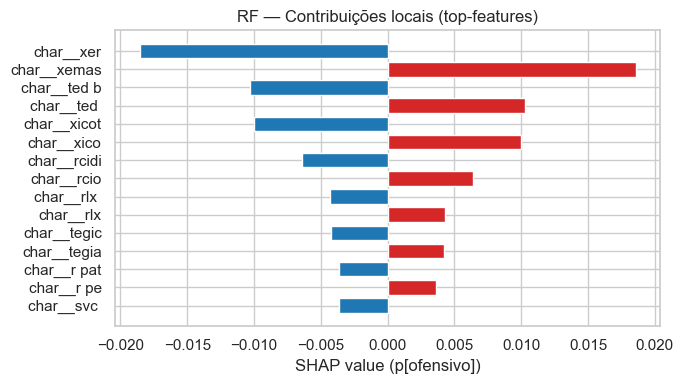

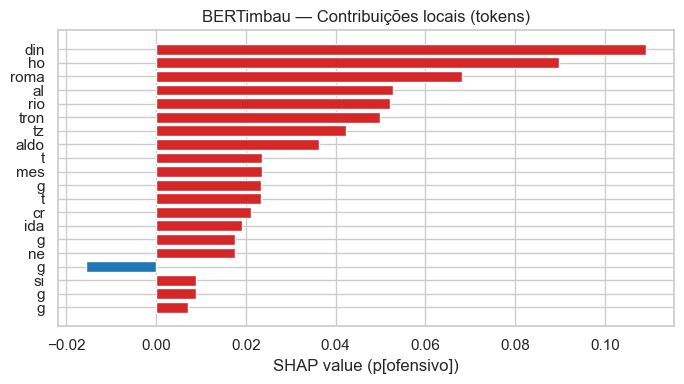

PartitionExplainer explainer: 2it [00:21, 21.43s/it]               


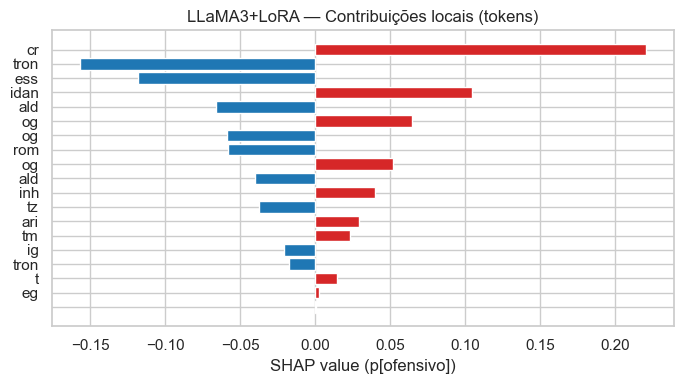


------------------------------------------------------------------------------------------
[idx=3] TRUE=0 | Texto: prefere usar damiao vizeu comentarios
  - RF: PRED=1 | score=0.575
  - BERT: PRED=0 | score=0.067
  - LLAMA: PRED=0 | score=0.020


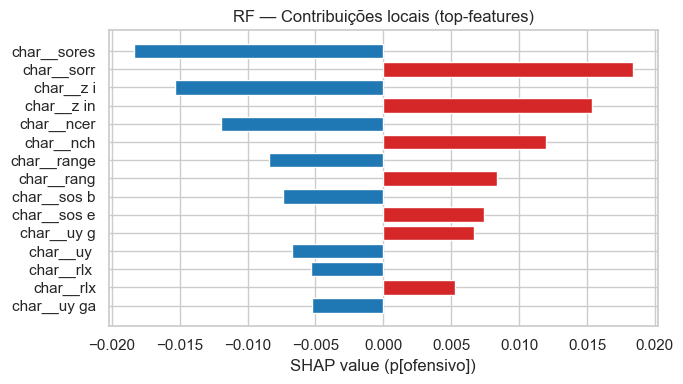

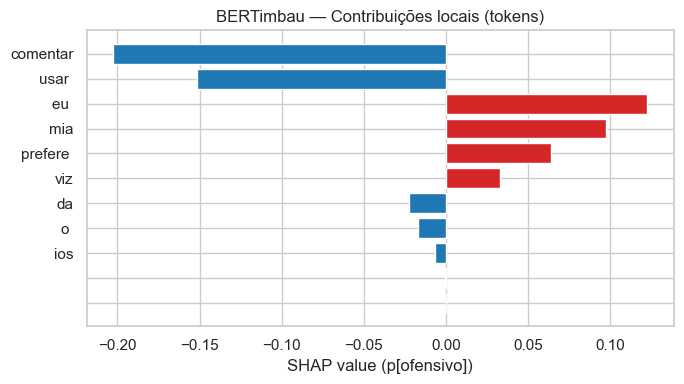

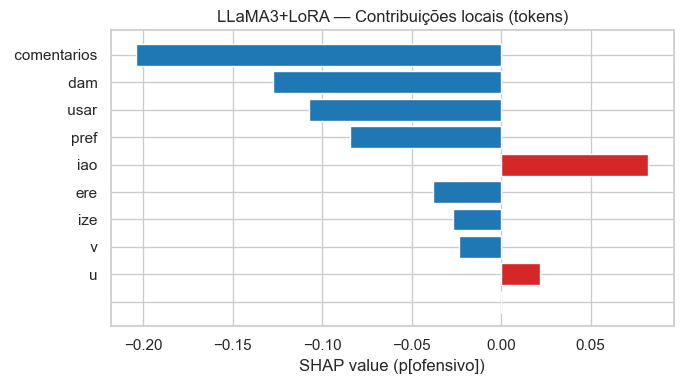


### Interpretação de erros — offcombr-3

------------------------------------------------------------------------------------------
[idx=1] TRUE=0 | Texto: bastou afundarem brasil
  - RF: PRED=0 | score=0.116
  - BERT: PRED=0 | score=0.024
  - LLAMA: PRED=1 | score=0.921


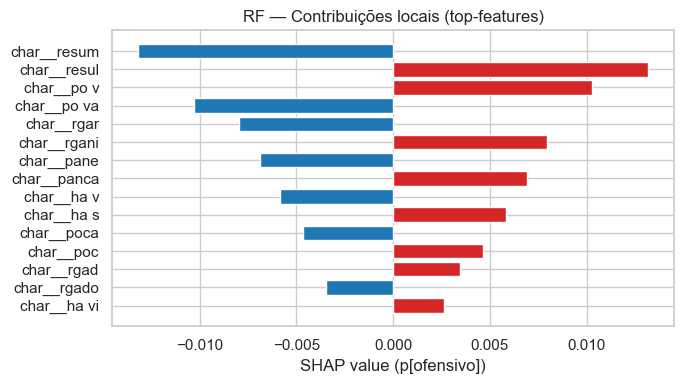

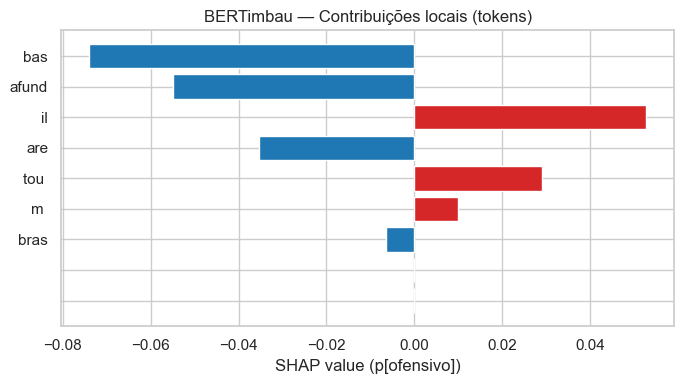

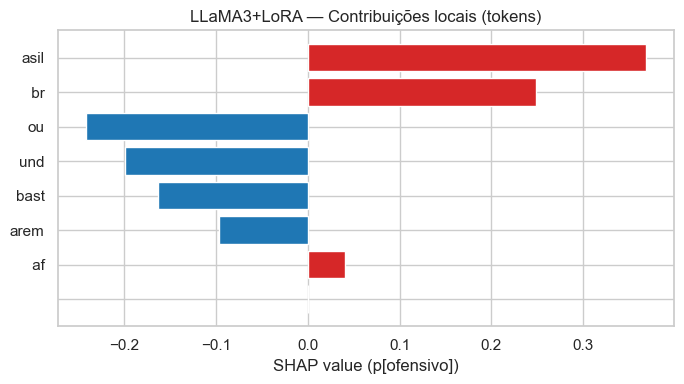


------------------------------------------------------------------------------------------
[idx=2] TRUE=0 | Texto: joga
  - RF: PRED=0 | score=0.242
  - BERT: PRED=0 | score=0.135
  - LLAMA: PRED=1 | score=0.982


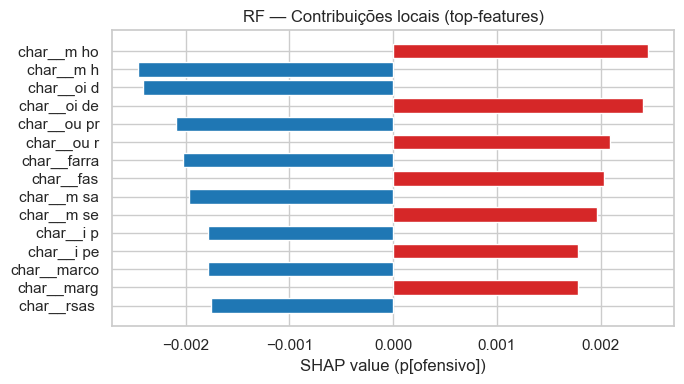

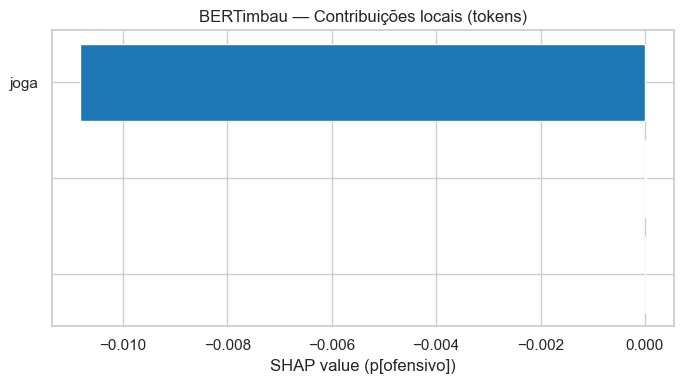

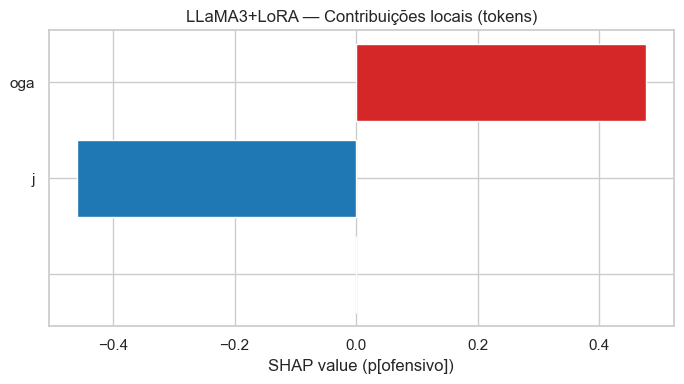


------------------------------------------------------------------------------------------
[idx=3] TRUE=0 | Texto: robozinho fica buscando pra censurar precisa elimina
  - RF: PRED=0 | score=0.246
  - BERT: PRED=1 | score=0.680
  - LLAMA: PRED=0 | score=0.135


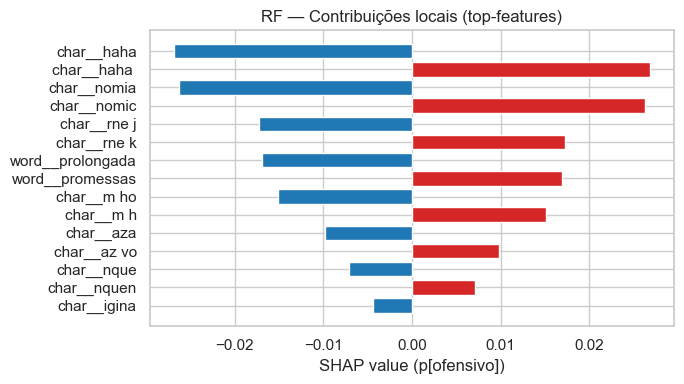

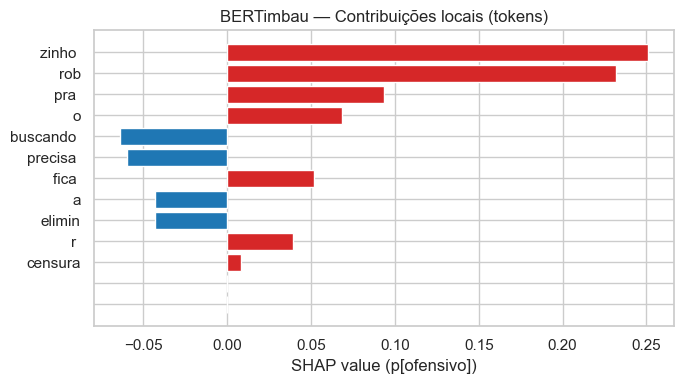

PartitionExplainer explainer: 2it [00:16, 16.04s/it]               


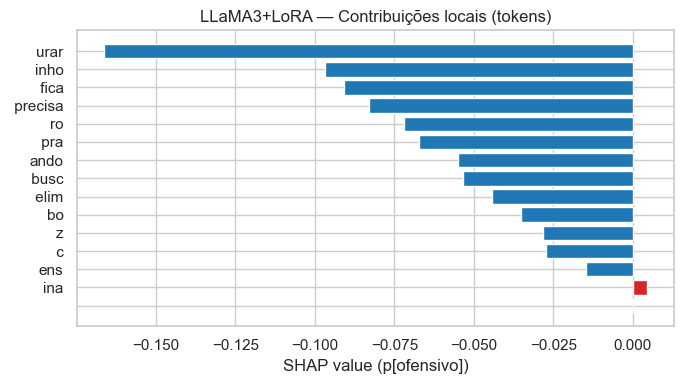

In [16]:
# =========================
# 7 + 7.1 — Avaliação consolidada (métricas, ROC/PR, confusão, correlação) + Interpretação de erros (RF × BERTimbau × LLaMA3+LoRA)
# =========================
import gc, re
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

sns.set(style="whitegrid", font_scale=1.0)

# ---------- Helpers de existência ----------
def _has(name): return name in globals()

# ---------- Scorers (probabilidade classe 1=ofensivo) ----------
def rf_predict_proba(pipe, texts, batch_size=2048):
    # compatível com 'feats' (FeatureUnion) ou 'tfidf'
    vec = pipe.named_steps["feats"] if "feats" in pipe.named_steps else pipe.named_steps["tfidf"]
    clf = pipe.named_steps["rf"]
    X = vec.transform(texts)
    return clf.predict_proba(X)[:, 1]

def bert_predict_proba(tok, model, texts, max_length=256, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval(); model.to(device)
    enc = tok(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    ds  = TensorDataset(enc["input_ids"], enc["attention_mask"])
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    probs = []
    with torch.no_grad():
        for ids, attn in loader:
            ids, attn = ids.to(device), attn.to(device)
            logits = model(input_ids=ids, attention_mask=attn).logits
            p1 = torch.softmax(logits, dim=-1)[:, 1].detach().cpu().numpy()
            probs.append(p1)
    return np.concatenate(probs, axis=0) if probs else np.array([])

def llama_predict_proba(tok, model, texts, max_length=256, batch_size=32):
    # Usa o classificador seq_cls treinado (Seção 6)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval(); model.to(device)
    enc = tok(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    ds  = TensorDataset(enc["input_ids"], enc["attention_mask"])
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    probs = []
    with torch.no_grad():
        for ids, attn in loader:
            ids, attn = ids.to(device), attn.to(device)
            logits = model(input_ids=ids, attention_mask=attn).logits
            p1 = torch.softmax(logits, dim=-1)[:, 1].detach().cpu().numpy()
            probs.append(p1)
    return np.concatenate(probs, axis=0) if probs else np.array([])

# ---------- SHAP locals em formato "barh" (padronizado com RF) ----------
def barh_signed(ax, names, values, top_k=15, title="Contribuições locais (SHAP)"):
    vals = np.asarray(values).ravel()
    names = np.asarray(names)
    # garante alinhamento
    n = min(len(vals), len(names))
    vals = vals[:n]; names = names[:n]
    k = min(top_k, n)
    ord_idx = np.argsort(np.abs(vals))[::-1][:k]
    v = vals[ord_idx]; lab = names[ord_idx]
    colors = ["tab:red" if x>0 else "tab:blue" for x in v]
    ax.barh(range(k), v, color=colors)
    ax.set_yticks(range(k)); ax.set_yticklabels(lab)
    ax.invert_yaxis()
    ax.set_xlabel("SHAP value (p[ofensivo])")
    ax.set_title(title)

def shap_local_rf(pipe, text, train_background_texts, seed=42, bg_size=200):
    vec = pipe.named_steps["feats"] if "feats" in pipe.named_steps else pipe.named_steps["tfidf"]
    rf  = pipe.named_steps["rf"]
    rng = np.random.default_rng(seed)
    bg_idx = rng.choice(len(train_background_texts), size=min(bg_size, len(train_background_texts)), replace=False)
    X_bg   = vec.transform([train_background_texts[i] for i in bg_idx]).toarray()
    expl   = shap.TreeExplainer(rf, data=X_bg, model_output="probability", feature_perturbation="interventional")
    x      = vec.transform([text]).toarray()
    sv     = expl.shap_values(x)
    sv1    = sv[1] if isinstance(sv, list) else sv
    return vec.get_feature_names_out(), np.asarray(sv1).reshape(-1)

def shap_local_text_model(predict_proba_fn, tokenizer, text, max_evals=300):
    # Explicador textual neutro → retorna Explanation com tokens e shap por token
    masker = shap.maskers.Text(tokenizer)
    expl   = shap.Explainer(predict_proba_fn, masker)
    sv     = expl([text], max_evals=max_evals)[0]
    vals   = sv.values
    if hasattr(vals, "ndim") and vals.ndim == 2:  # (1, n_tokens)
        vals = vals[0]
    tokens = [t for t in sv.data]
    # remove especiais
    if hasattr(tokenizer, "all_special_tokens"):
        keep = [t not in tokenizer.all_special_tokens for t in tokens]
        tokens = np.array(tokens)[keep]
        vals   = np.array(vals)[keep]
    return tokens, vals

# ---------- Métricas por modelo ----------
def metrics_from_scores(y_true, y_score, threshold=0.5):
    y_pred = (np.asarray(y_score) >= threshold).astype(int)
    # Macro
    acc = accuracy_score(y_true, y_pred)
    p_m, r_m, f1_m, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    # Classe positiva (ofensivo=1)
    p_pos, r_pos, f1_pos, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
    # p_pos[1], r_pos[1], f1_pos[1]
    return {
        "accuracy": float(acc),
        "precision_macro": float(p_m),
        "recall_macro": float(r_m),
        "f1_macro": float(f1_m),
        "precision_pos": float(p_pos[1]),
        "recall_pos": float(r_pos[1]),
        "f1_pos": float(f1_pos[1]),
        "y_pred": y_pred
    }

# ---------- Avaliação e plots comparativos por dataset ----------
def avaliar_resultados(resultados, y_test, cfg_name):
    """
    resultados: lista de dicts por modelo, cada um com:
      - 'Modelo', 'y_score' e métricas (accuracy, precision_macro, recall_macro, f1_macro, precision_pos, recall_pos, f1_pos).
    """
    # Tabela limpa para print
    df_resultados = pd.DataFrame([{k: v for k, v in r.items() if k not in ("y_score","y_pred")} for r in resultados])
    print(f"\n=== Comparação de Modelos - {cfg_name.upper()} ===")
    display(df_resultados)

    # ----- Gráficos de barras comparativos por métrica (macro e classe positiva) -----
    long = df_resultados.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")
    long = long[~long["Métrica"].isin(["cfg"])]
    plt.figure(figsize=(12,6))
    sns.barplot(data=long, x="Métrica", y="Valor", hue="Modelo")
    plt.title(f"Comparação de métricas — {cfg_name.upper()}"); plt.ylim(0,1)
    plt.xticks(rotation=30); plt.tight_layout(); plt.show()

    # ----- Curvas ROC comparativas -----
    plt.figure(figsize=(8,6))
    for r in resultados:
        fpr, tpr, _ = roc_curve(y_test, r["y_score"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{r['Modelo']} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"Curvas ROC — {cfg_name.upper()}"); plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

    # ----- Curvas Precision–Recall comparativas -----
    plt.figure(figsize=(8,6))
    for r in resultados:
        precision, recall, _ = precision_recall_curve(y_test, r["y_score"])
        ap = average_precision_score(y_test, r["y_score"])
        plt.plot(recall, precision, lw=2, label=f"{r['Modelo']} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Curvas Precision–Recall — {cfg_name.upper()}"); plt.legend(loc="lower left"); plt.tight_layout(); plt.show()

    # ----- Matrizes de confusão por modelo -----
    for r in resultados:
        y_pred = r["y_pred"]
        cm = confusion_matrix(y_test, y_pred, labels=[0,1])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Não-ofensivo","Ofensivo"],
                    yticklabels=["Não-ofensivo","Ofensivo"])
        plt.title(f"Matriz de Confusão — {r['Modelo']} ({cfg_name.upper()})")
        plt.ylabel("Verdadeiro"); plt.xlabel("Predito")
        plt.tight_layout(); plt.show()

    # ----- Heatmap de correlação entre métricas -----
    num_cols = ["accuracy","precision_macro","recall_macro","f1_macro","precision_pos","recall_pos","f1_pos"]
    corr_df = df_resultados.set_index("Modelo")[num_cols].astype(float)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Correlação entre métricas — {cfg_name.upper()}"); plt.tight_layout(); plt.show()

    return df_resultados

# ---------- Monta resultados por config (RF, BERT, LLaMA) ----------
def coletar_resultados_cfg(cfg):
    y_true = np.asarray(splits[cfg]["test_y"])
    resultados = []

    # RF - usa texto pré-processado
    if _has("rf_pipes") and cfg in rf_pipes:
        texts = list(splits[cfg]["test_text"])
        proba = rf_predict_proba(rf_pipes[cfg], texts)
        mets  = metrics_from_scores(y_true, proba)
        resultados.append({"Modelo":"RandomForest", "cfg":cfg, "y_score":proba, **mets})

    # Logistic Regression (char+word TF-IDF) - usa texto pré-processado
    if _has("lr_pipes") and cfg in lr_pipes:
        texts = list(splits[cfg]["test_text"])
        word_vec = lr_pipes[cfg]["word_vec"]
        char_vec = lr_pipes[cfg]["char_vec"]
        clf      = lr_pipes[cfg]["clf"]
        Xw = word_vec.transform(texts)
        Xc = char_vec.transform(texts)
        from scipy.sparse import hstack
        X  = hstack([Xw, Xc])
        proba = clf.predict_proba(X)[:, 1]
        mets  = metrics_from_scores(y_true, proba)
        resultados.append({"Modelo":"LogReg (char+word TF-IDF)", "cfg":cfg, "y_score":proba, **mets})

    # BERT - usa texto bruto (raw)
    if _has("bert_tok") and _has("bert_model") and cfg in bert_tok and cfg in bert_model:
        texts = list(splits[cfg]["test_text_raw"]) if "test_text_raw" in splits[cfg] else list(splits[cfg]["test_text"])
        proba = bert_predict_proba(bert_tok[cfg], bert_model[cfg], texts)
        mets  = metrics_from_scores(y_true, proba)
        resultados.append({"Modelo":"BERTimbau", "cfg":cfg, "y_score":proba, **mets})

    # LLaMA - usa texto bruto (raw)
    if _has("llama_tok") and _has("llama_model") and cfg in llama_tok and cfg in llama_model:
        texts = list(splits[cfg]["test_text_raw"]) if "test_text_raw" in splits[cfg] else list(splits[cfg]["test_text"])
        proba = llama_predict_proba(llama_tok[cfg], llama_model[cfg], texts)
        mets  = metrics_from_scores(y_true, proba)
        resultados.append({"Modelo":"LLaMA3+LoRA", "cfg":cfg, "y_score":proba, **mets})

    return resultados, y_true

# ---------- Execução por dataset ----------
tabelas_cfg = {}
for cfg in CONFIGS:
    resultados, y_test = coletar_resultados_cfg(cfg)
    if not resultados:
        print(f"[{cfg}] Nenhum modelo disponível para comparação.");
        continue
    df_res = avaliar_resultados(resultados, y_test, cfg)
    tabelas_cfg[cfg] = df_res

# ---------- Consolidação entre datasets (tabela e gráficos) ----------
if tabelas_cfg:
    tabela_final = pd.concat({k: v.set_index("Modelo") for k, v in tabelas_cfg.items()}, axis=0)
    print("\n=== Tabela consolidada (por dataset) ===")
    display(tabela_final)

    # Barras comparando F1 macro por dataset
    plot_df = tabela_final.reset_index().rename(columns={"level_0":"Dataset"})
    plt.figure(figsize=(12,6))
    sns.barplot(data=plot_df, x="Modelo", y="f1_macro", hue="Dataset")
    plt.title("Comparação de F1-macro entre datasets"); plt.ylim(0,1); plt.tight_layout(); plt.show()

    # Barras comparando Accuracy por dataset
    plt.figure(figsize=(12,6))
    sns.barplot(data=plot_df, x="Modelo", y="accuracy", hue="Dataset")
    plt.title("Comparação de Accuracy entre datasets"); plt.ylim(0,1); plt.tight_layout(); plt.show()

# =========================
# 7.1 — Interpretação de erros (padronizada tipo RF para todos)
# =========================
def _get_mis_idx(y_true, y_pred):
    return np.where(np.asarray(y_true) != np.asarray(y_pred))[0].tolist()

def interpretar_erros(cfg, K=3, top_k_rf=15, max_evals_text=300):
    print(f"\n### Interpretação de erros — {cfg}")
    texts = list(splits[cfg]["test_text"]); y_true = np.asarray(splits[cfg]["test_y"])

    preds = {}
    scorers = {}

    # RF
    if _has("rf_pipes") and cfg in rf_pipes:
        proba = rf_predict_proba(rf_pipes[cfg], texts); yhat = (proba >= 0.5).astype(int)
        preds["RF"] = yhat; scorers["RF"] = proba
    # BERT
    if _has("bert_tok") and _has("bert_model") and cfg in bert_tok and cfg in bert_model:
        proba = bert_predict_proba(bert_tok[cfg], bert_model[cfg], texts); yhat = (proba >= 0.5).astype(int)
        preds["BERT"] = yhat; scorers["BERT"] = proba
    # LLaMA
    if _has("llama_tok") and _has("llama_model") and cfg in llama_tok and cfg in llama_model:
        proba = llama_predict_proba(llama_tok[cfg], llama_model[cfg], texts); yhat = (proba >= 0.5).astype(int)
        preds["LLAMA"] = yhat; scorers["LLAMA"] = proba

    if not preds:
        print("Nenhum modelo disponível."); return

    # Índices onde ao menos um modelo errou
    mis_union = set()
    for name, yhat in preds.items():
        mis_union.update(_get_mis_idx(y_true, yhat))
    mis_union = sorted(mis_union)[:K]
    if not mis_union:
        print("Sem erros para mostrar."); return

    # Background de treino para RF SHAP
    tr_texts = list(splits[cfg]["train_text"])

    for i in mis_union:
        print("\n" + "-"*90)
        snippet = texts[i] if len(texts[i]) < 500 else texts[i][:500] + "…"
        print(f"[idx={i}] TRUE={y_true[i]} | Texto: {snippet}")
        for name, yhat in preds.items():
            print(f"  - {name}: PRED={yhat[i]} | score={scorers[name][i]:.3f}")

        # RF: barh de features TF-IDF
        if "RF" in preds:
            try:
                names, vals = shap_local_rf(rf_pipes[cfg], texts[i], tr_texts, seed=SEED, bg_size=200)
                fig, ax = plt.subplots(1, 1, figsize=(7, 4))
                barh_signed(ax, names, vals, top_k=top_k_rf, title="RF — Contribuições locais (top-features)")
                plt.tight_layout(); plt.show()
            except Exception as e:
                print("[RF] SHAP falhou:", e)

        # BERT: barh por token (signed SHAP)
        if "BERT" in preds:
            try:
                fn = lambda xs: bert_predict_proba(bert_tok[cfg], bert_model[cfg], xs)
                tokens, vals = shap_local_text_model(fn, bert_tok[cfg], texts[i], max_evals=max_evals_text)
                fig, ax = plt.subplots(1, 1, figsize=(7, 4))
                barh_signed(ax, tokens, vals, top_k=20, title="BERTimbau — Contribuições locais (tokens)")
                plt.tight_layout(); plt.show()
            except Exception as e:
                print("[BERT] SHAP falhou:", e)

        # LLaMA: barh por token (signed SHAP)
        if "LLAMA" in preds:
            try:
                fn = lambda xs: llama_predict_proba(llama_tok[cfg], llama_model[cfg], xs)
                tokens, vals = shap_local_text_model(fn, llama_tok[cfg], texts[i], max_evals=max_evals_text)
                fig, ax = plt.subplots(1, 1, figsize=(7, 4))
                barh_signed(ax, tokens, vals, top_k=20, title="LLaMA3+LoRA — Contribuições locais (tokens)")
                plt.tight_layout(); plt.show()
            except Exception as e:
                print("[LLaMA] SHAP falhou:", e)

# Executa interpretação de erros (K amostras por dataset)
for cfg in CONFIGS:
    interpretar_erros(cfg, K=3, top_k_rf=15, max_evals_text=300)